# SSVEP Character Classification with DiffE

In [1]:
#!pip install ema-pytorch

In [1]:
import os
import sys
# 26 13
#!git clone https://github.com/diffe2023/Diff-E.git
sys.path.append(r'C:\Users\shaoy\Diff-E')


In [2]:
import math
from einops import reduce
from functools import partial
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
#from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA on GPU!")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using CUDA on GPU!


In [3]:
# Uncomment this if you want to use Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#load and preprocess data


We retain the original SSVEP data preprocessing procedures, including:

    Chebyshev bandpass filtering (6–90 Hz),
    Noise removal and segmentation using a sliding window of 250 samples, followed by manual channel-wise standardization (subtracting the mean and dividing by the standard deviation),
    Downsampling from 1000 Hz to 250 Hz.

In this work, we directly load the preprocessed character-level files "S#_chars.npy" for subsequent training.

Unlike the original setup where models are trained separately for each subject, we train a single model jointly across all subjects by concatenating all subjects' data.

In [4]:
# Define a function to perform z-score normalization on the data
def zscore_norm(data):
    # Calculate the mean and standard deviation for each channel in each batch
    mean = torch.mean(data, dim=(1, 2))
    std = torch.std(data, dim=(1, 2))

    # Subtract the mean from each channel in each batch and divide by the standard deviation
    norm_data = (data - mean[:, None, None]) / std[:, None, None]

    return norm_data


# Define a function to perform min-max normalization on the data
def minmax_norm(data):
    # Calculate the minimum and maximum values for each channel and sequence in the batch
    min_vals = torch.min(data, dim=-1)[0]
    max_vals = torch.max(data, dim=-1)[0]

    # Scale the data to the range [0, 1]
    norm_data = (data - min_vals.unsqueeze(-1)) / (
        max_vals.unsqueeze(-1) - min_vals.unsqueeze(-1)
    )

    return norm_data

In [5]:
'''
class EEGDataset(Dataset):
    "Characterizes a dataset for PyTorch"

    def __init__(self, X, Y, transform=None):
        "Initialization"
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Load data and get label
        x = self.X[index]
        y = self.Y[index]
        if self.transform:
            x = self.transform(x)
        return x.squeeze(), y

In [6]:
'''
def load_data(root_dir, subject, session=None):
    filename = f"S{subject}_chars.npy"
    file_path = os.path.join(root_dir, filename)
    data = np.load(file_path)  # shape: [26, 6, 64, 250]

    X = data.reshape(-1, 64, 250)  # [26*6, 64, 250]
    Y = np.repeat(np.arange(26), 6)  # label：0~25，each character repeats 6 times

    X = torch.from_numpy(X).float()
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

#70% train-15% val-15% test
def get_dataloader(X, Y, batch_size, batch_size_val, batch_size_test, seed, shuffle=True):
    # train and test+val
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=0.3, stratify=Y, random_state=seed, shuffle=shuffle
    )

    # val and test
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=seed, shuffle=shuffle
    )

    train_set = EEGDataset(X_train, Y_train)
    val_set = EEGDataset(X_val, Y_val)
    test_set = EEGDataset(X_test, Y_test)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_set, batch_size=batch_size2, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size2, shuffle=False)

    return train_loader, val_loader, test_loader


In [7]:
'''
def load_all_subjects(root_dir, subject_ids, session=None):
    all_X, all_Y = [], []
    for sid in subject_ids:
        X, Y = load_data(root_dir=root_dir, subject=sid, session=session)
        # print(f"[Subject {sid}] X: {X.shape}, Y: {Y.shape}")
        # if X.shape[0] != Y.shape[0]:
        #     print(f"Mismatch at subject {sid}!")
        all_X.append(X)
        all_Y.append(Y)
    X = torch.cat(all_X, dim=0)
    Y = torch.cat(all_Y, dim=0)
    return X, Y

In [5]:
seed = 43
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  43


In [9]:
'''
subject_chars_dir = r'C:\LTI 11785 Introduction to deep learning\project\SSVEP\chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 43
shuffle = True

# load all subjects' data
X, Y = load_all_subjects(subject_chars_dir, subject_ids)
train_loader, val_loader, test_loader = get_dataloader(X, Y, batch_size, batch_size2, batch_size2, seed, shuffle=shuffle)


In [1]:
class EEGDataset(Dataset):
    def __init__(self, features, labels, augment=False):
        self.features = features
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        if self.augment:
            # apply your augmentation logic here
            x = self.apply_augmentation(x)

        return x, y

    def apply_augmentation(self, x):
        # define any augmentation wanted
        return x


def get_dataloader(file_path_X, file_path_y, batch_size=64, shuffle=False, augment=False):
    X = np.load(file_path_X)
    y = np.load(file_path_y)
    X_T = torch.tensor(X, dtype=torch.float32)
    y_T = torch.tensor(y, dtype=torch.float32)  # y is already 1-hot, long in case use cross-entropy
    
    dataset = EEGDataset(X_T, y_T, augment=augment)  # passed the tensors
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


train_loader = get_dataloader('processed_data/X_train.npy', 
                              'processed_data/y_train.npy', 
                              batch_size=128, shuffle=True)
val_loader   = get_dataloader('processed_data/X_val.npy', 
                              'processed_data/y_val.npy', 
                              batch_size=128, shuffle=True)
test_loader  = get_dataloader('processed_data/X_test1.npy', 
                              'processed_data/y_test1.npy', 
                              batch_size=128, shuffle=True)


NameError: name 'Dataset' is not defined

In [7]:
for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f" - X shape: {X_batch.shape}")
    print(f" - y shape: {y_batch.shape}")
    if batch_idx == 1:  # Print only the first two batches
        break

Batch 1
 - X shape: torch.Size([128, 64, 250])
 - y shape: torch.Size([128, 40])
Batch 2
 - X shape: torch.Size([128, 64, 250])
 - y shape: torch.Size([128, 40])


In [18]:
#torch.set_printoptions(threshold=6000)
#print(Y)

In [17]:
#print(X)

#model

The overall model follows the original GitHub implementation, with a few necessary adjustments to align tensor time dimensions. Specifically, we aligned the temporal dimensions between up2 + temb and down1, up3 and x, and x_hat and x. These changes are clearly marked with comments in the code.

In [8]:
#define diffE model
def get_padding(kernel_size, dilation=1):
    return int((kernel_size * dilation - dilation) / 2)


# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


'''Create a sinusoidal positional embedding of the positions.'''
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device   # cast all operations on the same device
        half_dim = self.dim // 2
        # positional encoding uses sine and cosine for different dimensions
        # each position is split into half, for sine and cosine
        emb = math.log(10000) / (half_dim - 1)
        # calculate logarithmic spacing factor
        # wavelengths form a geometric progression from 2pi to 2e4pi
        # provide a variety of frequencies to encode different positions
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        # create a tensor of size (half_dim)
        # each entry is a step in the geometric progression
        # represents the scaling factor for each dimension of the positional encoding
        emb = x[:, None] * emb[None, :]
        # scales the positions in x by the scaling factors computed previously
        # broadcast to apply the scaling across all dimensions
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        # the sine and cosine functions are applied to the scaled positions
        # concatenate along the last dimension to form the final positional embedding
        return emb


"""
https://arxiv.org/abs/1903.10520
weight standardization purportedly works synergistically with group normalization
Standardize the weights of the convolution layers similarly to how batch norm
standarizes activations.
"""
class WeightStandardizedConv1d(nn.Conv1d):

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3  # avoid divide by zero

        weight = self.weight  # convolutional weights of the layer
        mean = reduce(weight, "o ... -> o 1 1", "mean")
        # preserve the first dimension (o, output channel)
        # reduce all other dimensions to size 1 (mean across all filter dimensions)
        var = reduce(weight, "o ... -> o 1 1", partial(torch.var, unbiased=False))
        # computes the variance along all dimensions except the first
        # use biased estimator for variance calculation (i.e., divide by n and not n-1)
        normalized_weight = (weight - mean) * (var + eps).rsqrt()
        # normalize the weight with calculated mean and var

        return F.conv1d(  # class variables defined with nn.Convid
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )



class ResidualConvBlock(nn.Module):  # inherits from nn.Module, a base class for a nn in PyTorch
    def __init__(self, inc: int, outc: int, kernel_size: int, stride=1, gn=8):
        super().__init__()
        """
        standard ResNet style convolutional block
        inc:         Number of input channels.
        outc:        Number of output channels.
        kernel_size: Size of the convolution kernel.
        stride:      Stride of the convolution, with a default of 1.
        gn:          Number of groups for Group Normalization, with a default of 8.
        """
        self.same_channels = inc == outc  # boolean flag if in and out channels equals
        self.ks = kernel_size
        self.conv = nn.Sequential(
            WeightStandardizedConv1d(inc, outc, self.ks, stride, get_padding(self.ks)),
            # weights are normalized to improve training
            nn.GroupNorm(gn, outc),
            # group normalization using gn groups
            # normalizes the outputs across specified group channels
            # help stabilize learning, forr small batch / diverse data distributions
            nn.PReLU(),
            # parametric ReLU
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv(x)  # use the defined conv sequence to output x1
        if self.same_channels:  # residual connection if in and out channels equals
            out = (x + x1) / 2
        else:  # otherwise just output the x1
            out = x1
        return out


'''Downsample the input feature maps.'''
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        '''
        in_channels:       Number of input channels.
        out_channels:      Number of output channels.
        kernel_size:       Size of the kernel in the convolutional layer.
        gn (optional):     Number of groups for group normalization in the convolutional block, with a default value of 8.
        factor (optional): The factor by which the spatial size will be reduced, with a default value of 2.
        '''
        super(UnetDown, self).__init__()
        # initializes the base class nn.Module
        self.pool = nn.MaxPool1d(factor)
        # 1d max pooling, reduce spatial dimensions by a factor of 'factor'
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)
        # call the previously defined residual conv block

    def forward(self, x):
        x = self.layer(x)  # do the 1d (residual) conv
        x = self.pool(x)   # then do the max pooling
        return x


'''Upsample the input feature maps.'''
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        # same stuff, just upsample instead of downsample
        super(UnetUp, self).__init__()
        self.pool = nn.Upsample(scale_factor=factor, mode="nearest")
        # the upsample by a factor of 'factor' and using the nearest neighbor interpolation
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)
        # same thing

    def forward(self, x):
        x = self.pool(x)
        # do the upsampling first
        x = self.layer(x)
        # then call the conv
        return x


'''Embed an input into a higher-dimensional space using a fully connected network.'''
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        """
        generic one layer FC NN for embedding things
        input_dim: The size of each input sample.
        emb_dim:   The size of the embedding dimension to which the input data is transformed.
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.PReLU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        # layers to transform the input data
        # simply linear-activate-linear transform to get to embedding dimension
        self.model = nn.Sequential(*layers)
        # sequential model calling the previously defined layers

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        # reshape x for correct number of features per data point
        # expected by the model input
        return self.model(x)  # return the output of the model


'''U-Net conditional on time t using sinusoidal positional embedding.'''
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, n_feat=256):
        super(ConditionalUNet, self).__init__()

        # number of input channels and features per layer
        self.in_channels = in_channels
        self.n_feat = n_feat

        # downsampling dimensions / num of features
        self.d1_out = n_feat * 1
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.d4_out = n_feat * 4
        
        # upsampling dimensions / num of features
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        # sinusoidal positional embedding
        self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.u1_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)

        # downsample and increase depth
        self.down1 = UnetDown(in_channels, self.d1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.d1_out, self.d2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.d2_out, self.d3_out, 1, gn=8, factor=2)

        # upsample and use skip connections
        self.up2 = UnetUp(self.d3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.u2_out + self.d2_out, self.u3_out, 1, gn=8, factor=2)
        self.up4 = UnetUp(self.u3_out + self.d1_out, self.u4_out, 1, gn=8, factor=2)

        # combines the output of last upsampling step with original input
        self.out = nn.Conv1d(self.u4_out + in_channels, in_channels, 1)

    def forward(self, x, t):
        # call and sequentially downsample the input, reduce size + increase depth
        down1 = self.down1(x)      # 2000 -> 1000
        down2 = self.down2(down1)  # 1000 -> 500
        down3 = self.down3(down2)  # 500  -> 250

        # embeds the time parameter using sinusoidal positional embeddings
        # reshape it for concatenation with feature maps
        temb = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]
        
        # up sampling with skip connections to add embedded time info
        up1 = self.up2(down3)  # 250 -> 500
        up2 = self.up3(torch.cat([up1 + temb, down2], 1))  # 500 -> 1000

        # Align the temporal dimension of up2 + temb and down1
        # ensure the dimensions match for concatenation by interpolating
        # to the minimum size between up2 and down1
        if (up2 + temb).shape[-1] != down1.shape[-1]:
            target_len = min((up2 + temb).shape[-1], down1.shape[-1])
            up2 = F.interpolate(up2, size=target_len)
            down1 = F.interpolate(down1, size=target_len)

        # do the final upsampling after combining the up2 and down1
        up3 = self.up4(torch.cat([up2 + temb, down1], 1))  # 1000 -> 2000

        # Align the temporal dimension of up3 and x
        # unsures the output dimensions matches the original input dimension
        # for final output
        if up3.shape[-1] != x.shape[-1]:
            target_len = min(up3.shape[-1], x.shape[-1])
            up3 = F.interpolate(up3, size=target_len)
            x = F.interpolate(x, size=target_len)

        # combines the final upsampling output with the original input
        # and pass through a 1d concolution
        out = self.out(torch.cat([up3, x], 1))  # 2000 -> 2000

        # down and up are the intermediate outputs, can be useful
        down = (down1, down2, down3)
        up = (up1, up2, up3)
        return out, down, up


'''Create the condensed representation.'''
class Encoder(nn.Module):
    # dim sets a fixed output channels dimension for each layer
    def __init__(self, in_channels, dim=512):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.e1_out = dim
        self.e2_out = dim
        self.e3_out = dim

        # 3 downsampling layers, each by a factor of 2
        self.down1 = UnetDown(in_channels, self.e1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.e1_out, self.e2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.e2_out, self.e3_out, 1, gn=8, factor=2)

        # average and max pooling
        self.avg_pooling = nn.AdaptiveAvgPool1d(output_size=1)
        self.max_pooling = nn.AdaptiveMaxPool1d(output_size=1)

        # activation
        self.act = nn.Tanh()

    def forward(self, x0):
        # Down sampling
        dn1 = self.down1(x0)   # 2048 -> 1024
        dn2 = self.down2(dn1)  # 1024 -> 512
        dn3 = self.down3(dn2)  # 512 -> 256

        # average pooling used to condense each feature map of the output
        # to a single average value, summarizing the features extracted
        # reshape z so the batch dimension is preserved while collapsing spatial dimension
        z = self.avg_pooling(dn3).view(-1, self.e3_out)  # [b, features]

        # return both the network output z and the intermediate outputs down
        down = (dn1, dn2, dn3)
        out = (down, z)
        return out


'''Gernerative part of the diffusion model.'''
class Decoder(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=40):
        super(Decoder, self).__init__()
        # size of inputs and outputs
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.d1_out = n_feat
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        # self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        # self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        # self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        # self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        # scale back up after scaled down by encoder
        self.up1 = UnetUp(self.d3_out + self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up2 = UnetUp(self.d2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv1d(
                self.d1_out + self.u3_out + in_channels * 2, in_channels, 1, 1, 0
            ),
        )

        # self.out = nn.Conv1d(self.u4_out+in_channels, in_channels, 1)
        self.pool = nn.AvgPool1d(2)

    def forward(self, x0, encoder_out, diffusion_out):
        # Encoder output
        down, z = encoder_out  # unpack the output from encoder
        dn1, dn2, dn3 = down  # unpack the downsampling layers (from encoder)

        # DDPM output
        x_hat, down_ddpm, up, t = diffusion_out  # unpack diffusion (U net) output
        dn11, dn22, dn33 = down_ddpm

        # embed context, time step
        # temb = self.sin_emb(t).view(-1, self.n_feat, 1) # [b, n_feat, 1]
        # temb1 = self.timeembed1(temb).view(-1, self.e3_out, 1) # [b, features]
        # temb2 = self.timeembed2(temb).view(-1, self.u2_out, 1) # [b, features]
        # temb3 = self.timeembed3(temb).view(-1, self.u3_out, 1) # [b, features]
        # ct2 = self.contextembed2(z).view(-1, self.u2_out, 1) # [b, n_feat, 1]
        # ct3 = self.contextembed3(z).view(-1, self.u3_out, 1) # [b, n_feat, 1]

        # Up sampling, use the class function defined earlier
        up1 = self.up1(torch.cat([dn3, dn33.detach()], 1))
        up2 = self.up2(torch.cat([up1, dn22.detach()], 1))
        out = self.up3(
            torch.cat([self.pool(x0), self.pool(x_hat.detach()), up2, dn11.detach()], 1)
        )
        # initial input, diffusion model output, output from second unsampling layer, features from d11
        return out


class DiffE(nn.Module):
    def __init__(self, encoder, decoder, fc):
        super(DiffE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.fc = fc

    def forward(self, x0, ddpm_out):
        encoder_out = self.encoder(x0)
        decoder_out = self.decoder(x0, encoder_out, ddpm_out)
        fc_out = self.fc(encoder_out[1])
        return decoder_out, fc_out


class DecoderNoDiff(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=40):
        super(DecoderNoDiff, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = n_feat

        self.sin_emb = SinusoidalPosEmb(n_feat)
        self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up2 = UnetUp(self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.e2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        # self.up4 = UnetUp(self.e1_out+self.u3_out, self.u4_out, 1, 1, gn=in_channels, factor=2, is_res=True)
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv1d(self.u3_out + self.e1_out + in_channels, in_channels, 1, 1, 0),
        )

        self.out = nn.Conv1d(self.u4_out, in_channels, 1)
        self.pool = nn.AvgPool1d(2)

    def forward(self, x0, x_hat, encoder_out, t):
        down, z = encoder_out
        dn1, dn2, dn3 = down
        tembd = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]
        tembd1 = self.timeembed1(self.sin_emb(t)).view(
            -1, self.e3_out, 1
        )  # [b, n_feat, 1]
        tembd2 = self.timeembed2(self.sin_emb(t)).view(
            -1, self.u2_out, 1
        )  # [b, n_feat, 1]
        tembd3 = self.timeembed3(self.sin_emb(t)).view(
            -1, self.u3_out, 1
        )  # [b, n_feat, 1]

        # Up sampling
        ddpm_loss = F.l1_loss(x0, x_hat, reduction="none")

        up2 = self.up2(dn3)  # 256 -> 512
        up3 = self.up3(torch.cat([up2, dn2], 1))  # 512 -> 1024
        out = self.up4(
            torch.cat([self.pool(x0), self.pool(x_hat), up3, dn1], 1)
        )  # 1024 -> 2048
        # out = self.out(torch.cat([out, x_hat], 1)) # 2048 -> 2048
        # out = self.out(out)
        return out


class LinearClassifier(nn.Module):
    def __init__(self, in_dim, latent_dim, emb_dim):
        super().__init__()
        self.linear_out = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=emb_dim),  # the out features should match the y dimension no?
        )

    def forward(self, x):
        x = self.linear_out(x)
        return x


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def sigmoid_beta_schedule(timesteps, start=-3, end=3, tau=1, clamp_min=1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (
        v_end - v_start
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def ddpm_schedules(beta1, beta2, T):
    # assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    # beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    beta_t = cosine_beta_schedule(T, s=0.008).float()
    # beta_t = sigmoid_beta_schedule(T).float()

    alpha_t = 1 - beta_t

    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)

    return {
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device

    def forward(self, x):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        x_t = self.sqrtab[_ts, None, None] * x + self.sqrtmab[_ts, None, None] * noise
        times = _ts / self.n_T
        output, down, up = self.nn_model(x_t, times)
        return output, down, up, noise, times

In [9]:
# Define model
num_classes = 40
channels = 64

n_T = 1000  # time step variable in the schedulers
ddpm_dim = 128
encoder_dim = 256
fc_dim = 512

ddpm_model = ConditionalUNet(in_channels=channels, n_feat=ddpm_dim).to(device)
ddpm = DDPM(nn_model=ddpm_model, betas=(1e-6, 1e-2), n_T=n_T, device=device).to(device)
encoder = Encoder(in_channels=channels, dim=encoder_dim).to(device)
decoder = Decoder(in_channels=channels, n_feat=ddpm_dim, encoder_dim=encoder_dim).to(device)
fc = LinearClassifier(encoder_dim, fc_dim, emb_dim=40).to(device)
diffe = DiffE(encoder, decoder, fc).to(device)

print("ddpm size: ", sum(p.numel() for p in ddpm.parameters()))
print("encoder size: ", sum(p.numel() for p in encoder.parameters()))
print("decoder size: ", sum(p.numel() for p in decoder.parameters()))
print("fc size: ", sum(p.numel() for p in fc.parameters()))

ddpm size:  265478
encoder size:  149763
decoder size:  156482
fc size:  416810


#train

In [10]:
# Criterion
criterion = nn.L1Loss()
criterion_class = nn.MSELoss()

# Define optimizer
base_lr, lr = 9e-5, 1.5e-3
optim1 = optim.RMSprop(ddpm.parameters(), lr=base_lr)
optim2 = optim.RMSprop(diffe.parameters(), lr=base_lr)

# EMAs
fc_ema = EMA(diffe.fc, beta=0.95, update_after_step=100, update_every=10,)

step_size = 150
scheduler1 = optim.lr_scheduler.CyclicLR(
    optimizer=optim1,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)
scheduler2 = optim.lr_scheduler.CyclicLR(
    optimizer=optim2,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)

In [11]:
# Evaluate function
def evaluate(encoder, fc, generator, device):
    labels = np.arange(0, 40)
    Y = []
    Y_hat = []
    for x, y in generator:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        encoder_out = encoder(x)
        y_hat = fc(encoder_out[1])
        y_hat = F.softmax(y_hat, dim=1)

        Y.append(y.detach().cpu())
        Y_hat.append(y_hat.detach().cpu())

    # List of tensors to tensor to numpy
    Y = torch.cat(Y, dim=0).numpy()  # (N, )
    Y_indices = Y.argmax(axis=1)
    Y_hat = torch.cat(Y_hat, dim=0).numpy()  # (N, 13): has to sum to 1 for each row

    # Accuracy and Confusion Matrix
    # changed all Y to Y_indices
    accuracy = top_k_accuracy_score(Y_indices, Y_hat, k=1, labels=labels)
    f1 = f1_score(Y_indices, Y_hat.argmax(axis=1), average="macro", labels=labels)
    recall = recall_score(Y_indices, Y_hat.argmax(axis=1), average="macro", labels=labels)
    precision = precision_score(Y_indices, Y_hat.argmax(axis=1), average="macro", labels=labels, zero_division=0)
    # the zero_division = 0 fixes cases where the prediction does not assign any sample to one or more classes
    # which results in a dividing by zero error
    # the zero_division = 0 sets those cases accuracy to zero
    auc = roc_auc_score(Y_indices, Y_hat, average="macro", multi_class="ovo", labels=labels)

    metrics = {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "auc": auc,
    }
    # df_cm = pd.DataFrame(confusion_matrix(Y, Y_hat.argmax(axis=1)))
    return metrics


In [12]:
# Train & Evaluate
args = argparse.Namespace()
args.device = device
args.subject = "ALL"
#args.root_dir = subject_chars_dir
subject = args.subject

num_epochs = 500
test_period = 1
start_test = test_period
alpha = 0.1

best_acc = 0
best_f1 = 0
best_recall = 0
best_precision = 0
best_auc = 0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

with tqdm(total=num_epochs, desc=f"Method ALL - Joint Training on All Subjects") as pbar:
    for epoch in range(num_epochs):
        ddpm.train()
        diffe.train()

        epoch_loss = 0
        num_batches = 0
        epoch_acc = 0
        total_samples = 0

        ############################## Train ###########################################
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            #y_cat = F.one_hot(y, num_classes=40).type(torch.FloatTensor).to(device)
            # Train DDPM
            optim1.zero_grad()
            x_hat, down, up, noise, t = ddpm(x)

            # Align the temporal dimension of x_hat and x
            if x_hat.shape[-1] != x.shape[-1]:
                target_len = min(x_hat.shape[-1], x.shape[-1])
                x_hat = F.interpolate(x_hat, size=target_len)
                x = F.interpolate(x, size=target_len)

            loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
            loss_ddpm.mean().backward()
            optim1.step()
            ddpm_out = x_hat, down, up, t

            # Train Diff-E
            optim2.zero_grad()
            decoder_out, fc_out = diffe(x, ddpm_out)

            loss_gap = criterion(decoder_out, loss_ddpm.detach())
            loss_c = criterion_class(fc_out, y)
            loss = loss_gap + alpha * loss_c
            loss.backward()
            optim2.step()

            # Optimizer scheduler step
            scheduler1.step()
            scheduler2.step()

            # EMA update
            fc_ema.update()

            epoch_loss += loss.item()
            num_batches += 1

            pred_labels = torch.argmax(fc_out, dim=1)
            y_indices = torch.argmax(y, dim=1)  # need a bit of change here
            correct = (pred_labels == y_indices).sum().item()
            epoch_acc += correct
            total_samples += y_indices.size(0)

        history["train_loss"].append(epoch_loss / num_batches)
        history["train_acc"].append(epoch_acc / total_samples)

        ############################## validation ###########################################
        with torch.no_grad():
            if epoch > start_test:
                test_period = 1
            if epoch % test_period == 0:
                ddpm.eval()
                diffe.eval()

                metrics_val = evaluate(diffe.encoder, fc_ema, val_loader, device)

                val_acc = metrics_val["accuracy"]
                history["val_acc"].append(val_acc)
                f1 = metrics_val["f1"]
                recall = metrics_val["recall"]
                precision = metrics_val["precision"]
                auc = metrics_val["auc"]

                val_loss = 0
                with torch.no_grad():
                    for x, y in val_loader:
                        x, y = x.to(device), y.to(device)
                        #y_cat = F.one_hot(y, num_classes=40).float().to(device)

                        x_hat, down, up, noise, t = ddpm(x)
                        ddpm_out = x_hat, down, up, t

                        if x_hat.shape[-1] != x.shape[-1]:
                            target_len = min(x_hat.shape[-1], x.shape[-1])
                            x_hat = F.interpolate(x_hat, size=target_len)
                            x = F.interpolate(x, size=target_len)

                        loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
                        decoder_out, fc_out = diffe(x, ddpm_out)

                        loss_gap = criterion(decoder_out, loss_ddpm)
                        loss_c = criterion_class(fc_out, y)

                        val_loss += (loss_gap + alpha * loss_c).item()
                history["val_loss"].append(val_loss / len(val_loader))

                best_acc_bool = val_acc > best_acc
                best_f1_bool = f1 > best_f1
                best_recall_bool = recall > best_recall
                best_precision_bool = precision > best_precision
                best_auc_bool = auc > best_auc

                if best_acc_bool:
                    best_acc = val_acc
                    #torch.save(diffe.state_dict(), f'/content/drive/MyDrive/project/model/ssvep/diffe_{subject}.pth')
                    torch.save(diffe.state_dict(), r'C:\LTI 11785 Introduction to deep learning\project\SSVEP\checkpoints\diffe_all_subjects.pth')
                if best_f1_bool:
                    best_f1 = f1
                if best_recall_bool:
                    best_recall = recall
                if best_precision_bool:
                    best_precision = precision
                if best_auc_bool:
                    best_auc = auc

                # print("Subject: {0}".format(subject))
                # # print("ddpm test loss: {0:.4f}".format(t_test_loss_ddpm/len(test_generator)))
                # # print("encoder test loss: {0:.4f}".format(t_test_loss_ed/len(test_generator)))
                # print("accuracy:  {0:.2f}%".format(acc*100), "best: {0:.2f}%".format(best_acc*100))
                # print("f1-score:  {0:.2f}%".format(f1*100), "best: {0:.2f}%".format(best_f1*100))
                # print("recall:    {0:.2f}%".format(recall*100), "best: {0:.2f}%".format(best_recall*100))
                # print("precision: {0:.2f}%".format(precision*100), "best: {0:.2f}%".format(best_precision*100))
                # print("auc:       {0:.2f}%".format(auc*100), "best: {0:.2f}%".format(best_auc*100))
                # writer.add_scalar(f"EEGNet/Accuracy/subject_{subject}", acc*100, epoch)
                # writer.add_scalar(f"EEGNet/F1-score/subject_{subject}", f1*100, epoch)
                # writer.add_scalar(f"EEGNet/Recall/subject_{subject}", recall*100, epoch)
                # writer.add_scalar(f"EEGNet/Precision/subject_{subject}", precision*100, epoch)
                # writer.add_scalar(f"EEGNet/AUC/subject_{subject}", auc*100, epoch)

                # if best_acc_bool or best_f1_bool or best_recall_bool or best_precision_bool or best_auc_bool:
                #     performance = {'subject': subject,
                #                 'epoch': epoch,
                #                 'accuracy': best_acc*100,
                #                 'f1_score': best_f1*100,
                #                 'recall': best_recall*100,
                #                 'precision': best_precision*100,
                #                 'auc': best_auc*100
                #                 }
                #     with open(output_file, 'a') as f:
                #         f.write(f"{performance['subject']}, {performance['epoch']}, {performance['accuracy']}, {performance['f1_score']}, {performance['recall']}, {performance['precision']}, {performance['auc']}\n")
                description = f"Val Accuracy: {val_acc*100:.2f}% | Best: {best_acc*100:.2f}%"
                pbar.set_description(f"Method ALL – Processing subject {subject} – {description}"
                )
        print(f"[Epoch {epoch+1}/{num_epochs}]")
        print(f"Train Loss: {history['train_loss'][-1]:.4f} | Train Acc: {history['train_acc'][-1]*100:.2f}%")
        print(f"Valid Loss: {history['val_loss'][-1]:.4f} | Valid Acc: {val_acc*100:.2f}%")
        
        pbar.update(1)

Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 2.50%:   0%|       | 1/500 [00:08<1:11:17,  8.57s/it]

[Epoch 1/500]
Train Loss: 0.4552 | Train Acc: 2.40%
Valid Loss: 0.3562 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 2.50%:   0%|       | 2/500 [00:14<1:00:04,  7.24s/it]

[Epoch 2/500]
Train Loss: 0.3329 | Train Acc: 2.62%
Valid Loss: 0.3024 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 2.50%:   1%|       | 3/500 [00:22<1:01:02,  7.37s/it]

[Epoch 3/500]
Train Loss: 0.3038 | Train Acc: 2.30%
Valid Loss: 0.2964 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 2.58%:   1%|       | 4/500 [00:29<1:01:22,  7.42s/it]

[Epoch 4/500]
Train Loss: 0.2762 | Train Acc: 2.38%
Valid Loss: 0.2540 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 2.58%:   1%|       | 5/500 [00:37<1:01:20,  7.44s/it]

[Epoch 5/500]
Train Loss: 0.2505 | Train Acc: 2.48%
Valid Loss: 0.2482 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 2.58%:   1%|       | 6/500 [00:44<1:01:11,  7.43s/it]

[Epoch 6/500]
Train Loss: 0.2492 | Train Acc: 3.02%
Valid Loss: 0.2416 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.42% | Best: 2.58%:   1%|       | 7/500 [00:52<1:00:52,  7.41s/it]

[Epoch 7/500]
Train Loss: 0.2435 | Train Acc: 2.58%
Valid Loss: 0.2387 | Valid Acc: 2.42%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 2.58%:   2%|       | 8/500 [00:59<1:00:36,  7.39s/it]

[Epoch 8/500]
Train Loss: 0.2511 | Train Acc: 2.33%
Valid Loss: 0.2517 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 2.58%:   2%|▏      | 9/500 [01:06<1:00:11,  7.35s/it]

[Epoch 9/500]
Train Loss: 0.2609 | Train Acc: 2.70%
Valid Loss: 0.2599 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 2.58%:   2%|▏       | 10/500 [01:13<59:41,  7.31s/it]

[Epoch 10/500]
Train Loss: 0.2611 | Train Acc: 2.35%
Valid Loss: 0.2438 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 3.17% | Best: 3.17%:   2%|▏     | 11/500 [01:21<1:00:31,  7.43s/it]

[Epoch 11/500]
Train Loss: 0.2407 | Train Acc: 2.37%
Valid Loss: 0.2433 | Valid Acc: 3.17%


Method ALL – Processing subject ALL – Val Accuracy: 2.67% | Best: 3.17%:   2%|▏     | 12/500 [01:29<1:00:42,  7.46s/it]

[Epoch 12/500]
Train Loss: 0.2379 | Train Acc: 2.27%
Valid Loss: 0.2369 | Valid Acc: 2.67%


Method ALL – Processing subject ALL – Val Accuracy: 2.83% | Best: 3.17%:   3%|▏       | 13/500 [01:36<59:25,  7.32s/it]

[Epoch 13/500]
Train Loss: 0.2375 | Train Acc: 2.40%
Valid Loss: 0.2287 | Valid Acc: 2.83%


Method ALL – Processing subject ALL – Val Accuracy: 2.75% | Best: 3.17%:   3%|▏       | 14/500 [01:43<59:43,  7.37s/it]

[Epoch 14/500]
Train Loss: 0.2386 | Train Acc: 2.55%
Valid Loss: 0.2435 | Valid Acc: 2.75%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.17%:   3%|▏       | 15/500 [01:51<59:51,  7.41s/it]

[Epoch 15/500]
Train Loss: 0.2491 | Train Acc: 2.58%
Valid Loss: 0.2458 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.67% | Best: 3.17%:   3%|▎       | 16/500 [01:58<59:35,  7.39s/it]

[Epoch 16/500]
Train Loss: 0.2548 | Train Acc: 2.32%
Valid Loss: 0.2429 | Valid Acc: 2.67%


Method ALL – Processing subject ALL – Val Accuracy: 2.67% | Best: 3.17%:   3%|▎       | 17/500 [02:05<59:14,  7.36s/it]

[Epoch 17/500]
Train Loss: 0.2421 | Train Acc: 2.55%
Valid Loss: 0.2361 | Valid Acc: 2.67%


Method ALL – Processing subject ALL – Val Accuracy: 3.00% | Best: 3.17%:   4%|▏     | 18/500 [02:13<1:00:55,  7.58s/it]

[Epoch 18/500]
Train Loss: 0.2364 | Train Acc: 2.77%
Valid Loss: 0.2426 | Valid Acc: 3.00%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 3.17%:   4%|▏     | 19/500 [02:21<1:00:31,  7.55s/it]

[Epoch 19/500]
Train Loss: 0.2341 | Train Acc: 1.97%
Valid Loss: 0.2345 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.75% | Best: 3.17%:   4%|▏     | 20/500 [02:29<1:00:38,  7.58s/it]

[Epoch 20/500]
Train Loss: 0.2349 | Train Acc: 2.47%
Valid Loss: 0.2415 | Valid Acc: 2.75%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.17%:   4%|▎     | 21/500 [02:37<1:01:39,  7.72s/it]

[Epoch 21/500]
Train Loss: 0.2407 | Train Acc: 2.70%
Valid Loss: 0.2401 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.17%:   4%|▎     | 22/500 [02:45<1:02:24,  7.83s/it]

[Epoch 22/500]
Train Loss: 0.2504 | Train Acc: 2.37%
Valid Loss: 0.2443 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.42% | Best: 3.17%:   5%|▎     | 23/500 [02:52<1:01:28,  7.73s/it]

[Epoch 23/500]
Train Loss: 0.2459 | Train Acc: 2.72%
Valid Loss: 0.2368 | Valid Acc: 2.42%


Method ALL – Processing subject ALL – Val Accuracy: 2.42% | Best: 3.17%:   5%|▎     | 24/500 [03:00<1:00:43,  7.66s/it]

[Epoch 24/500]
Train Loss: 0.2351 | Train Acc: 2.67%
Valid Loss: 0.2346 | Valid Acc: 2.42%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 3.17%:   5%|▎     | 25/500 [03:07<1:00:29,  7.64s/it]

[Epoch 25/500]
Train Loss: 0.2323 | Train Acc: 2.77%
Valid Loss: 0.2348 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 3.17%:   5%|▎     | 26/500 [03:15<1:01:12,  7.75s/it]

[Epoch 26/500]
Train Loss: 0.2373 | Train Acc: 2.85%
Valid Loss: 0.2286 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 3.17%:   5%|▎     | 27/500 [03:23<1:00:11,  7.64s/it]

[Epoch 27/500]
Train Loss: 0.2339 | Train Acc: 3.03%
Valid Loss: 0.2397 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 3.75% | Best: 3.75%:   6%|▍       | 28/500 [03:30<59:25,  7.55s/it]

[Epoch 28/500]
Train Loss: 0.2439 | Train Acc: 2.37%
Valid Loss: 0.2359 | Valid Acc: 3.75%


Method ALL – Processing subject ALL – Val Accuracy: 2.67% | Best: 3.75%:   6%|▍       | 29/500 [03:37<58:49,  7.49s/it]

[Epoch 29/500]
Train Loss: 0.2458 | Train Acc: 2.55%
Valid Loss: 0.2391 | Valid Acc: 2.67%


Method ALL – Processing subject ALL – Val Accuracy: 3.08% | Best: 3.75%:   6%|▍       | 30/500 [03:45<58:38,  7.49s/it]

[Epoch 30/500]
Train Loss: 0.2327 | Train Acc: 2.43%
Valid Loss: 0.2310 | Valid Acc: 3.08%


Method ALL – Processing subject ALL – Val Accuracy: 3.33% | Best: 3.75%:   6%|▍       | 31/500 [03:52<58:18,  7.46s/it]

[Epoch 31/500]
Train Loss: 0.2348 | Train Acc: 2.50%
Valid Loss: 0.2261 | Valid Acc: 3.33%


Method ALL – Processing subject ALL – Val Accuracy: 3.25% | Best: 3.75%:   6%|▌       | 32/500 [04:00<58:06,  7.45s/it]

[Epoch 32/500]
Train Loss: 0.2328 | Train Acc: 2.33%
Valid Loss: 0.2328 | Valid Acc: 3.25%


Method ALL – Processing subject ALL – Val Accuracy: 2.75% | Best: 3.75%:   7%|▌       | 33/500 [04:07<57:41,  7.41s/it]

[Epoch 33/500]
Train Loss: 0.2297 | Train Acc: 2.57%
Valid Loss: 0.2369 | Valid Acc: 2.75%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.75%:   7%|▌       | 34/500 [04:15<58:02,  7.47s/it]

[Epoch 34/500]
Train Loss: 0.2394 | Train Acc: 2.33%
Valid Loss: 0.2453 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.75%:   7%|▌       | 35/500 [04:22<57:59,  7.48s/it]

[Epoch 35/500]
Train Loss: 0.2457 | Train Acc: 2.12%
Valid Loss: 0.2407 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.42% | Best: 3.75%:   7%|▌       | 36/500 [04:30<57:48,  7.48s/it]

[Epoch 36/500]
Train Loss: 0.2379 | Train Acc: 2.63%
Valid Loss: 0.2318 | Valid Acc: 2.42%


Method ALL – Processing subject ALL – Val Accuracy: 2.25% | Best: 3.75%:   7%|▌       | 37/500 [04:37<57:42,  7.48s/it]

[Epoch 37/500]
Train Loss: 0.2329 | Train Acc: 2.55%
Valid Loss: 0.2375 | Valid Acc: 2.25%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.75%:   8%|▌       | 38/500 [04:45<57:31,  7.47s/it]

[Epoch 38/500]
Train Loss: 0.2324 | Train Acc: 2.85%
Valid Loss: 0.2305 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.92% | Best: 3.75%:   8%|▌       | 39/500 [04:52<57:11,  7.44s/it]

[Epoch 39/500]
Train Loss: 0.2305 | Train Acc: 3.28%
Valid Loss: 0.2333 | Valid Acc: 2.92%


Method ALL – Processing subject ALL – Val Accuracy: 2.83% | Best: 3.75%:   8%|▋       | 40/500 [04:59<56:58,  7.43s/it]

[Epoch 40/500]
Train Loss: 0.2365 | Train Acc: 3.08%
Valid Loss: 0.2364 | Valid Acc: 2.83%


Method ALL – Processing subject ALL – Val Accuracy: 2.83% | Best: 3.75%:   8%|▋       | 41/500 [05:07<56:53,  7.44s/it]

[Epoch 41/500]
Train Loss: 0.2404 | Train Acc: 2.63%
Valid Loss: 0.2397 | Valid Acc: 2.83%


Method ALL – Processing subject ALL – Val Accuracy: 2.58% | Best: 3.75%:   8%|▋       | 42/500 [05:14<57:18,  7.51s/it]

[Epoch 42/500]
Train Loss: 0.2417 | Train Acc: 2.55%
Valid Loss: 0.2372 | Valid Acc: 2.58%


Method ALL – Processing subject ALL – Val Accuracy: 2.42% | Best: 3.75%:   9%|▋       | 43/500 [05:22<57:05,  7.50s/it]

[Epoch 43/500]
Train Loss: 0.2363 | Train Acc: 2.97%
Valid Loss: 0.2307 | Valid Acc: 2.42%


Method ALL – Processing subject ALL – Val Accuracy: 2.50% | Best: 3.75%:   9%|▋       | 44/500 [05:29<57:04,  7.51s/it]

[Epoch 44/500]
Train Loss: 0.2300 | Train Acc: 3.17%
Valid Loss: 0.2360 | Valid Acc: 2.50%


Method ALL – Processing subject ALL – Val Accuracy: 2.67% | Best: 3.75%:   9%|▋       | 45/500 [05:37<56:22,  7.43s/it]

[Epoch 45/500]
Train Loss: 0.2285 | Train Acc: 3.35%
Valid Loss: 0.2277 | Valid Acc: 2.67%


Method ALL – Processing subject ALL – Val Accuracy: 3.25% | Best: 3.75%:   9%|▋       | 46/500 [05:44<56:21,  7.45s/it]

[Epoch 46/500]
Train Loss: 0.2307 | Train Acc: 3.87%
Valid Loss: 0.2395 | Valid Acc: 3.25%


Method ALL – Processing subject ALL – Val Accuracy: 3.33% | Best: 3.75%:   9%|▊       | 47/500 [05:52<55:59,  7.42s/it]

[Epoch 47/500]
Train Loss: 0.2353 | Train Acc: 3.42%
Valid Loss: 0.2448 | Valid Acc: 3.33%


Method ALL – Processing subject ALL – Val Accuracy: 3.08% | Best: 3.75%:  10%|▊       | 48/500 [05:59<55:44,  7.40s/it]

[Epoch 48/500]
Train Loss: 0.2424 | Train Acc: 2.82%
Valid Loss: 0.2401 | Valid Acc: 3.08%


Method ALL – Processing subject ALL – Val Accuracy: 4.08% | Best: 4.08%:  10%|▊       | 49/500 [06:06<55:39,  7.41s/it]

[Epoch 49/500]
Train Loss: 0.2332 | Train Acc: 3.30%
Valid Loss: 0.2380 | Valid Acc: 4.08%


Method ALL – Processing subject ALL – Val Accuracy: 4.00% | Best: 4.08%:  10%|▊       | 50/500 [06:14<55:51,  7.45s/it]

[Epoch 50/500]
Train Loss: 0.2322 | Train Acc: 3.53%
Valid Loss: 0.2330 | Valid Acc: 4.00%


Method ALL – Processing subject ALL – Val Accuracy: 4.17% | Best: 4.17%:  10%|▊       | 51/500 [06:21<55:50,  7.46s/it]

[Epoch 51/500]
Train Loss: 0.2304 | Train Acc: 4.37%
Valid Loss: 0.2314 | Valid Acc: 4.17%


Method ALL – Processing subject ALL – Val Accuracy: 4.58% | Best: 4.58%:  10%|▊       | 52/500 [06:29<55:21,  7.41s/it]

[Epoch 52/500]
Train Loss: 0.2309 | Train Acc: 4.78%
Valid Loss: 0.2345 | Valid Acc: 4.58%


Method ALL – Processing subject ALL – Val Accuracy: 4.75% | Best: 4.75%:  11%|▊       | 53/500 [06:36<55:30,  7.45s/it]

[Epoch 53/500]
Train Loss: 0.2357 | Train Acc: 4.15%
Valid Loss: 0.2364 | Valid Acc: 4.75%


Method ALL – Processing subject ALL – Val Accuracy: 4.08% | Best: 4.75%:  11%|▊       | 54/500 [06:43<55:04,  7.41s/it]

[Epoch 54/500]
Train Loss: 0.2379 | Train Acc: 3.53%
Valid Loss: 0.2419 | Valid Acc: 4.08%


Method ALL – Processing subject ALL – Val Accuracy: 4.92% | Best: 4.92%:  11%|▉       | 55/500 [06:51<55:14,  7.45s/it]

[Epoch 55/500]
Train Loss: 0.2364 | Train Acc: 3.57%
Valid Loss: 0.2332 | Valid Acc: 4.92%


Method ALL – Processing subject ALL – Val Accuracy: 4.75% | Best: 4.92%:  11%|▉       | 56/500 [06:58<53:59,  7.30s/it]

[Epoch 56/500]
Train Loss: 0.2298 | Train Acc: 3.78%
Valid Loss: 0.2344 | Valid Acc: 4.75%


Method ALL – Processing subject ALL – Val Accuracy: 5.00% | Best: 5.00%:  11%|▉       | 57/500 [07:05<53:56,  7.31s/it]

[Epoch 57/500]
Train Loss: 0.2323 | Train Acc: 5.00%
Valid Loss: 0.2302 | Valid Acc: 5.00%


Method ALL – Processing subject ALL – Val Accuracy: 4.75% | Best: 5.00%:  12%|▉       | 58/500 [07:13<54:51,  7.45s/it]

[Epoch 58/500]
Train Loss: 0.2307 | Train Acc: 5.60%
Valid Loss: 0.2323 | Valid Acc: 4.75%


Method ALL – Processing subject ALL – Val Accuracy: 5.00% | Best: 5.00%:  12%|▉       | 59/500 [07:21<55:56,  7.61s/it]

[Epoch 59/500]
Train Loss: 0.2323 | Train Acc: 4.70%
Valid Loss: 0.2262 | Valid Acc: 5.00%


Method ALL – Processing subject ALL – Val Accuracy: 4.75% | Best: 5.00%:  12%|▉       | 60/500 [07:29<56:25,  7.69s/it]

[Epoch 60/500]
Train Loss: 0.2345 | Train Acc: 4.57%
Valid Loss: 0.2324 | Valid Acc: 4.75%


Method ALL – Processing subject ALL – Val Accuracy: 5.00% | Best: 5.00%:  12%|▉       | 61/500 [07:36<55:32,  7.59s/it]

[Epoch 61/500]
Train Loss: 0.2370 | Train Acc: 4.10%
Valid Loss: 0.2344 | Valid Acc: 5.00%


Method ALL – Processing subject ALL – Val Accuracy: 5.58% | Best: 5.58%:  12%|▉       | 62/500 [07:44<55:16,  7.57s/it]

[Epoch 62/500]
Train Loss: 0.2294 | Train Acc: 4.35%
Valid Loss: 0.2279 | Valid Acc: 5.58%


Method ALL – Processing subject ALL – Val Accuracy: 6.08% | Best: 6.08%:  13%|█       | 63/500 [07:51<54:35,  7.50s/it]

[Epoch 63/500]
Train Loss: 0.2280 | Train Acc: 4.88%
Valid Loss: 0.2341 | Valid Acc: 6.08%


Method ALL – Processing subject ALL – Val Accuracy: 5.67% | Best: 6.08%:  13%|█       | 64/500 [07:59<54:16,  7.47s/it]

[Epoch 64/500]
Train Loss: 0.2303 | Train Acc: 5.93%
Valid Loss: 0.2305 | Valid Acc: 5.67%


Method ALL – Processing subject ALL – Val Accuracy: 5.92% | Best: 6.08%:  13%|█       | 65/500 [08:06<54:31,  7.52s/it]

[Epoch 65/500]
Train Loss: 0.2300 | Train Acc: 6.23%
Valid Loss: 0.2308 | Valid Acc: 5.92%


Method ALL – Processing subject ALL – Val Accuracy: 5.58% | Best: 6.08%:  13%|█       | 66/500 [08:14<54:44,  7.57s/it]

[Epoch 66/500]
Train Loss: 0.2324 | Train Acc: 5.75%
Valid Loss: 0.2378 | Valid Acc: 5.58%


Method ALL – Processing subject ALL – Val Accuracy: 5.08% | Best: 6.08%:  13%|█       | 67/500 [08:21<54:30,  7.55s/it]

[Epoch 67/500]
Train Loss: 0.2388 | Train Acc: 4.85%
Valid Loss: 0.2449 | Valid Acc: 5.08%


Method ALL – Processing subject ALL – Val Accuracy: 5.92% | Best: 6.08%:  14%|█       | 68/500 [08:29<53:33,  7.44s/it]

[Epoch 68/500]
Train Loss: 0.2336 | Train Acc: 5.28%
Valid Loss: 0.2302 | Valid Acc: 5.92%


Method ALL – Processing subject ALL – Val Accuracy: 5.92% | Best: 6.08%:  14%|█       | 69/500 [08:36<53:09,  7.40s/it]

[Epoch 69/500]
Train Loss: 0.2323 | Train Acc: 5.43%
Valid Loss: 0.2342 | Valid Acc: 5.92%


Method ALL – Processing subject ALL – Val Accuracy: 5.58% | Best: 6.08%:  14%|█       | 70/500 [08:43<52:59,  7.39s/it]

[Epoch 70/500]
Train Loss: 0.2297 | Train Acc: 6.43%
Valid Loss: 0.2277 | Valid Acc: 5.58%


Method ALL – Processing subject ALL – Val Accuracy: 5.33% | Best: 6.08%:  14%|█▏      | 71/500 [08:51<52:56,  7.41s/it]

[Epoch 71/500]
Train Loss: 0.2268 | Train Acc: 6.55%
Valid Loss: 0.2308 | Valid Acc: 5.33%


Method ALL – Processing subject ALL – Val Accuracy: 6.08% | Best: 6.08%:  14%|█▏      | 72/500 [08:58<52:58,  7.43s/it]

[Epoch 72/500]
Train Loss: 0.2355 | Train Acc: 6.03%
Valid Loss: 0.2430 | Valid Acc: 6.08%


Method ALL – Processing subject ALL – Val Accuracy: 5.92% | Best: 6.08%:  15%|█▏      | 73/500 [09:06<52:44,  7.41s/it]

[Epoch 73/500]
Train Loss: 0.2334 | Train Acc: 5.12%
Valid Loss: 0.2401 | Valid Acc: 5.92%


Method ALL – Processing subject ALL – Val Accuracy: 5.58% | Best: 6.08%:  15%|█▏      | 74/500 [09:13<52:50,  7.44s/it]

[Epoch 74/500]
Train Loss: 0.2321 | Train Acc: 5.32%
Valid Loss: 0.2317 | Valid Acc: 5.58%


Method ALL – Processing subject ALL – Val Accuracy: 5.83% | Best: 6.08%:  15%|█▏      | 75/500 [09:21<52:53,  7.47s/it]

[Epoch 75/500]
Train Loss: 0.2291 | Train Acc: 5.87%
Valid Loss: 0.2300 | Valid Acc: 5.83%


Method ALL – Processing subject ALL – Val Accuracy: 5.75% | Best: 6.08%:  15%|█▏      | 76/500 [09:28<52:36,  7.44s/it]

[Epoch 76/500]
Train Loss: 0.2316 | Train Acc: 6.50%
Valid Loss: 0.2289 | Valid Acc: 5.75%


Method ALL – Processing subject ALL – Val Accuracy: 5.67% | Best: 6.08%:  15%|█▏      | 77/500 [09:35<52:34,  7.46s/it]

[Epoch 77/500]
Train Loss: 0.2286 | Train Acc: 7.43%
Valid Loss: 0.2354 | Valid Acc: 5.67%


Method ALL – Processing subject ALL – Val Accuracy: 6.67% | Best: 6.67%:  16%|█▏      | 78/500 [09:43<52:24,  7.45s/it]

[Epoch 78/500]
Train Loss: 0.2295 | Train Acc: 7.35%
Valid Loss: 0.2343 | Valid Acc: 6.67%


Method ALL – Processing subject ALL – Val Accuracy: 6.00% | Best: 6.67%:  16%|█▎      | 79/500 [09:50<52:21,  7.46s/it]

[Epoch 79/500]
Train Loss: 0.2324 | Train Acc: 5.80%
Valid Loss: 0.2340 | Valid Acc: 6.00%


Method ALL – Processing subject ALL – Val Accuracy: 4.92% | Best: 6.67%:  16%|█▎      | 80/500 [09:58<51:56,  7.42s/it]

[Epoch 80/500]
Train Loss: 0.2347 | Train Acc: 6.52%
Valid Loss: 0.2322 | Valid Acc: 4.92%


Method ALL – Processing subject ALL – Val Accuracy: 5.83% | Best: 6.67%:  16%|█▎      | 81/500 [10:05<51:48,  7.42s/it]

[Epoch 81/500]
Train Loss: 0.2302 | Train Acc: 6.45%
Valid Loss: 0.2286 | Valid Acc: 5.83%


Method ALL – Processing subject ALL – Val Accuracy: 5.83% | Best: 6.67%:  16%|█▎      | 82/500 [10:13<51:51,  7.44s/it]

[Epoch 82/500]
Train Loss: 0.2310 | Train Acc: 7.05%
Valid Loss: 0.2318 | Valid Acc: 5.83%


Method ALL – Processing subject ALL – Val Accuracy: 6.25% | Best: 6.67%:  17%|█▎      | 83/500 [10:20<51:53,  7.47s/it]

[Epoch 83/500]
Train Loss: 0.2300 | Train Acc: 8.33%
Valid Loss: 0.2363 | Valid Acc: 6.25%


Method ALL – Processing subject ALL – Val Accuracy: 5.92% | Best: 6.67%:  17%|█▎      | 84/500 [10:27<51:14,  7.39s/it]

[Epoch 84/500]
Train Loss: 0.2307 | Train Acc: 8.73%
Valid Loss: 0.2273 | Valid Acc: 5.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 7.00%:  17%|█▎      | 85/500 [10:35<51:30,  7.45s/it]

[Epoch 85/500]
Train Loss: 0.2331 | Train Acc: 8.12%
Valid Loss: 0.2329 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 5.33% | Best: 7.00%:  17%|█▍      | 86/500 [10:42<51:21,  7.44s/it]

[Epoch 86/500]
Train Loss: 0.2330 | Train Acc: 6.90%
Valid Loss: 0.2413 | Valid Acc: 5.33%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 7.00%:  17%|█▍      | 87/500 [10:50<51:25,  7.47s/it]

[Epoch 87/500]
Train Loss: 0.2313 | Train Acc: 6.82%
Valid Loss: 0.2287 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 7.25%:  18%|█▍      | 88/500 [10:57<51:20,  7.48s/it]

[Epoch 88/500]
Train Loss: 0.2280 | Train Acc: 7.82%
Valid Loss: 0.2276 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 6.50% | Best: 7.25%:  18%|█▍      | 89/500 [11:05<51:20,  7.50s/it]

[Epoch 89/500]
Train Loss: 0.2286 | Train Acc: 9.43%
Valid Loss: 0.2312 | Valid Acc: 6.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 7.25%:  18%|█▍      | 90/500 [11:12<51:09,  7.49s/it]

[Epoch 90/500]
Train Loss: 0.2270 | Train Acc: 10.23%
Valid Loss: 0.2321 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 5.83% | Best: 7.25%:  18%|█▍      | 91/500 [11:20<51:33,  7.56s/it]

[Epoch 91/500]
Train Loss: 0.2332 | Train Acc: 9.60%
Valid Loss: 0.2334 | Valid Acc: 5.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 7.42%:  18%|█▍      | 92/500 [11:27<50:54,  7.49s/it]

[Epoch 92/500]
Train Loss: 0.2341 | Train Acc: 8.50%
Valid Loss: 0.2275 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 7.42%:  19%|█▍      | 93/500 [11:35<50:46,  7.49s/it]

[Epoch 93/500]
Train Loss: 0.2303 | Train Acc: 7.20%
Valid Loss: 0.2322 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 7.58%:  19%|█▌      | 94/500 [11:42<50:23,  7.45s/it]

[Epoch 94/500]
Train Loss: 0.2302 | Train Acc: 8.00%
Valid Loss: 0.2316 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 7.75%:  19%|█▌      | 95/500 [11:50<50:25,  7.47s/it]

[Epoch 95/500]
Train Loss: 0.2267 | Train Acc: 10.05%
Valid Loss: 0.2325 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 8.42%:  19%|█▌      | 96/500 [11:57<50:02,  7.43s/it]

[Epoch 96/500]
Train Loss: 0.2294 | Train Acc: 11.93%
Valid Loss: 0.2263 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 8.42%:  19%|█▌      | 97/500 [12:05<49:50,  7.42s/it]

[Epoch 97/500]
Train Loss: 0.2254 | Train Acc: 12.22%
Valid Loss: 0.2351 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 8.42%:  20%|█▌      | 98/500 [12:12<49:55,  7.45s/it]

[Epoch 98/500]
Train Loss: 0.2308 | Train Acc: 10.68%
Valid Loss: 0.2378 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 8.42%:  20%|█▌      | 99/500 [12:20<49:59,  7.48s/it]

[Epoch 99/500]
Train Loss: 0.2360 | Train Acc: 8.73%
Valid Loss: 0.2324 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 6.75% | Best: 8.42%:  20%|█▍     | 100/500 [12:27<49:35,  7.44s/it]

[Epoch 100/500]
Train Loss: 0.2326 | Train Acc: 9.58%
Valid Loss: 0.2251 | Valid Acc: 6.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 8.42%:  20%|█▍     | 101/500 [12:34<49:38,  7.46s/it]

[Epoch 101/500]
Train Loss: 0.2311 | Train Acc: 11.98%
Valid Loss: 0.2276 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 8.42%:  20%|█▍     | 102/500 [12:42<49:12,  7.42s/it]

[Epoch 102/500]
Train Loss: 0.2273 | Train Acc: 13.62%
Valid Loss: 0.2327 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 8.42%:  21%|█▍     | 103/500 [12:49<49:09,  7.43s/it]

[Epoch 103/500]
Train Loss: 0.2284 | Train Acc: 15.42%
Valid Loss: 0.2300 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 6.25% | Best: 8.42%:  21%|█▍     | 104/500 [12:57<48:57,  7.42s/it]

[Epoch 104/500]
Train Loss: 0.2309 | Train Acc: 13.62%
Valid Loss: 0.2282 | Valid Acc: 6.25%


Method ALL – Processing subject ALL – Val Accuracy: 6.42% | Best: 8.42%:  21%|█▍     | 105/500 [13:04<48:42,  7.40s/it]

[Epoch 105/500]
Train Loss: 0.2346 | Train Acc: 10.95%
Valid Loss: 0.2357 | Valid Acc: 6.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 8.42%:  21%|█▍     | 106/500 [13:11<48:40,  7.41s/it]

[Epoch 106/500]
Train Loss: 0.2328 | Train Acc: 10.63%
Valid Loss: 0.2269 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.08% | Best: 8.42%:  21%|█▍     | 107/500 [13:19<49:30,  7.56s/it]

[Epoch 107/500]
Train Loss: 0.2282 | Train Acc: 12.28%
Valid Loss: 0.2409 | Valid Acc: 7.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 8.42%:  22%|█▌     | 108/500 [13:27<49:13,  7.53s/it]

[Epoch 108/500]
Train Loss: 0.2288 | Train Acc: 15.27%
Valid Loss: 0.2281 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 8.42%:  22%|█▌     | 109/500 [13:34<48:56,  7.51s/it]

[Epoch 109/500]
Train Loss: 0.2291 | Train Acc: 18.65%
Valid Loss: 0.2317 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 8.42%:  22%|█▌     | 110/500 [13:42<48:39,  7.49s/it]

[Epoch 110/500]
Train Loss: 0.2271 | Train Acc: 16.45%
Valid Loss: 0.2324 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 8.42%:  22%|█▌     | 111/500 [13:49<48:30,  7.48s/it]

[Epoch 111/500]
Train Loss: 0.2336 | Train Acc: 13.75%
Valid Loss: 0.2347 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 8.42%:  22%|█▌     | 112/500 [13:57<48:10,  7.45s/it]

[Epoch 112/500]
Train Loss: 0.2316 | Train Acc: 12.53%
Valid Loss: 0.2312 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 8.42%:  23%|█▌     | 113/500 [14:04<47:55,  7.43s/it]

[Epoch 113/500]
Train Loss: 0.2295 | Train Acc: 13.73%
Valid Loss: 0.2297 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 8.42%:  23%|█▌     | 114/500 [14:11<47:47,  7.43s/it]

[Epoch 114/500]
Train Loss: 0.2301 | Train Acc: 16.03%
Valid Loss: 0.2360 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 8.42%:  23%|█▌     | 115/500 [14:19<47:45,  7.44s/it]

[Epoch 115/500]
Train Loss: 0.2284 | Train Acc: 20.75%
Valid Loss: 0.2279 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 8.42%:  23%|█▌     | 116/500 [14:26<47:40,  7.45s/it]

[Epoch 116/500]
Train Loss: 0.2274 | Train Acc: 20.45%
Valid Loss: 0.2321 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 8.42%:  23%|█▋     | 117/500 [14:34<47:26,  7.43s/it]

[Epoch 117/500]
Train Loss: 0.2308 | Train Acc: 16.67%
Valid Loss: 0.2300 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 8.42%:  24%|█▋     | 118/500 [14:41<47:30,  7.46s/it]

[Epoch 118/500]
Train Loss: 0.2303 | Train Acc: 14.22%
Valid Loss: 0.2279 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 8.42%:  24%|█▋     | 119/500 [14:49<47:16,  7.44s/it]

[Epoch 119/500]
Train Loss: 0.2288 | Train Acc: 14.60%
Valid Loss: 0.2307 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.92% | Best: 8.42%:  24%|█▋     | 120/500 [14:56<47:10,  7.45s/it]

[Epoch 120/500]
Train Loss: 0.2295 | Train Acc: 17.40%
Valid Loss: 0.2269 | Valid Acc: 7.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 8.42%:  24%|█▋     | 121/500 [15:04<46:59,  7.44s/it]

[Epoch 121/500]
Train Loss: 0.2261 | Train Acc: 22.45%
Valid Loss: 0.2315 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 8.42%:  24%|█▋     | 122/500 [15:11<46:49,  7.43s/it]

[Epoch 122/500]
Train Loss: 0.2270 | Train Acc: 25.38%
Valid Loss: 0.2260 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 8.42%:  25%|█▋     | 123/500 [15:18<46:51,  7.46s/it]

[Epoch 123/500]
Train Loss: 0.2285 | Train Acc: 21.80%
Valid Loss: 0.2271 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.92% | Best: 8.42%:  25%|█▋     | 124/500 [15:26<46:21,  7.40s/it]

[Epoch 124/500]
Train Loss: 0.2288 | Train Acc: 18.08%
Valid Loss: 0.2360 | Valid Acc: 7.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 8.42%:  25%|█▊     | 125/500 [15:33<46:24,  7.42s/it]

[Epoch 125/500]
Train Loss: 0.2304 | Train Acc: 17.32%
Valid Loss: 0.2300 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 8.42%:  25%|█▊     | 126/500 [15:40<46:00,  7.38s/it]

[Epoch 126/500]
Train Loss: 0.2292 | Train Acc: 18.93%
Valid Loss: 0.2337 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.92% | Best: 8.42%:  25%|█▊     | 127/500 [15:48<46:08,  7.42s/it]

[Epoch 127/500]
Train Loss: 0.2297 | Train Acc: 23.97%
Valid Loss: 0.2309 | Valid Acc: 7.92%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 8.42%:  26%|█▊     | 128/500 [15:55<46:11,  7.45s/it]

[Epoch 128/500]
Train Loss: 0.2295 | Train Acc: 28.45%
Valid Loss: 0.2343 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 8.42%:  26%|█▊     | 129/500 [16:03<45:56,  7.43s/it]

[Epoch 129/500]
Train Loss: 0.2248 | Train Acc: 27.12%
Valid Loss: 0.2294 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 8.42%:  26%|█▊     | 130/500 [16:10<45:35,  7.39s/it]

[Epoch 130/500]
Train Loss: 0.2295 | Train Acc: 22.12%
Valid Loss: 0.2292 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 8.42%:  26%|█▊     | 131/500 [16:18<45:44,  7.44s/it]

[Epoch 131/500]
Train Loss: 0.2303 | Train Acc: 19.77%
Valid Loss: 0.2261 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 8.42%:  26%|█▊     | 132/500 [16:25<45:47,  7.47s/it]

[Epoch 132/500]
Train Loss: 0.2277 | Train Acc: 20.32%
Valid Loss: 0.2261 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 8.42%:  27%|█▊     | 133/500 [16:33<45:47,  7.49s/it]

[Epoch 133/500]
Train Loss: 0.2282 | Train Acc: 25.45%
Valid Loss: 0.2310 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 8.42%:  27%|█▉     | 134/500 [16:40<45:24,  7.44s/it]

[Epoch 134/500]
Train Loss: 0.2290 | Train Acc: 30.87%
Valid Loss: 0.2258 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 8.42%:  27%|█▉     | 135/500 [16:48<45:22,  7.46s/it]

[Epoch 135/500]
Train Loss: 0.2239 | Train Acc: 33.13%
Valid Loss: 0.2344 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 8.50%:  27%|█▉     | 136/500 [16:55<45:14,  7.46s/it]

[Epoch 136/500]
Train Loss: 0.2270 | Train Acc: 27.08%
Valid Loss: 0.2263 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 8.50%:  27%|█▉     | 137/500 [17:03<45:07,  7.46s/it]

[Epoch 137/500]
Train Loss: 0.2285 | Train Acc: 22.48%
Valid Loss: 0.2286 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 8.50%:  28%|█▉     | 138/500 [17:10<45:02,  7.46s/it]

[Epoch 138/500]
Train Loss: 0.2311 | Train Acc: 22.47%
Valid Loss: 0.2285 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 8.50%:  28%|█▉     | 139/500 [17:17<44:49,  7.45s/it]

[Epoch 139/500]
Train Loss: 0.2263 | Train Acc: 27.20%
Valid Loss: 0.2335 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 8.50%:  28%|█▉     | 140/500 [17:25<44:43,  7.45s/it]

[Epoch 140/500]
Train Loss: 0.2280 | Train Acc: 33.15%
Valid Loss: 0.2338 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 8.58%:  28%|█▉     | 141/500 [17:32<44:34,  7.45s/it]

[Epoch 141/500]
Train Loss: 0.2282 | Train Acc: 38.52%
Valid Loss: 0.2279 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 8.58%:  28%|█▉     | 142/500 [17:40<44:24,  7.44s/it]

[Epoch 142/500]
Train Loss: 0.2286 | Train Acc: 33.82%
Valid Loss: 0.2368 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 8.58%:  29%|██     | 143/500 [17:47<43:57,  7.39s/it]

[Epoch 143/500]
Train Loss: 0.2305 | Train Acc: 28.22%
Valid Loss: 0.2409 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 8.58%:  29%|██     | 144/500 [17:54<43:57,  7.41s/it]

[Epoch 144/500]
Train Loss: 0.2318 | Train Acc: 24.82%
Valid Loss: 0.2267 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 8.58%:  29%|██     | 145/500 [18:02<43:53,  7.42s/it]

[Epoch 145/500]
Train Loss: 0.2279 | Train Acc: 28.13%
Valid Loss: 0.2274 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 9.08% | Best: 9.08%:  29%|██     | 146/500 [18:09<43:53,  7.44s/it]

[Epoch 146/500]
Train Loss: 0.2273 | Train Acc: 35.42%
Valid Loss: 0.2287 | Valid Acc: 9.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.08%:  29%|██     | 147/500 [18:17<43:53,  7.46s/it]

[Epoch 147/500]
Train Loss: 0.2269 | Train Acc: 42.17%
Valid Loss: 0.2293 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.08%:  30%|██     | 148/500 [18:24<43:53,  7.48s/it]

[Epoch 148/500]
Train Loss: 0.2284 | Train Acc: 41.18%
Valid Loss: 0.2282 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.08%:  30%|██     | 149/500 [18:32<43:50,  7.50s/it]

[Epoch 149/500]
Train Loss: 0.2267 | Train Acc: 32.88%
Valid Loss: 0.2309 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.08%:  30%|██     | 150/500 [18:39<43:28,  7.45s/it]

[Epoch 150/500]
Train Loss: 0.2292 | Train Acc: 29.60%
Valid Loss: 0.2335 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 9.25% | Best: 9.25%:  30%|██     | 151/500 [18:47<43:25,  7.46s/it]

[Epoch 151/500]
Train Loss: 0.2275 | Train Acc: 28.80%
Valid Loss: 0.2330 | Valid Acc: 9.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.25%:  30%|██▏    | 152/500 [18:54<43:13,  7.45s/it]

[Epoch 152/500]
Train Loss: 0.2297 | Train Acc: 36.03%
Valid Loss: 0.2271 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.25%:  31%|██▏    | 153/500 [19:02<43:03,  7.44s/it]

[Epoch 153/500]
Train Loss: 0.2275 | Train Acc: 45.35%
Valid Loss: 0.2333 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.25%:  31%|██▏    | 154/500 [19:09<43:01,  7.46s/it]

[Epoch 154/500]
Train Loss: 0.2280 | Train Acc: 48.50%
Valid Loss: 0.2305 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.25%:  31%|██▏    | 155/500 [19:17<42:41,  7.42s/it]

[Epoch 155/500]
Train Loss: 0.2276 | Train Acc: 41.35%
Valid Loss: 0.2323 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.25%:  31%|██▏    | 156/500 [19:24<42:47,  7.46s/it]

[Epoch 156/500]
Train Loss: 0.2275 | Train Acc: 35.72%
Valid Loss: 0.2277 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.25%:  31%|██▏    | 157/500 [19:32<42:45,  7.48s/it]

[Epoch 157/500]
Train Loss: 0.2270 | Train Acc: 31.52%
Valid Loss: 0.2265 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.25%:  32%|██▏    | 158/500 [19:39<42:19,  7.43s/it]

[Epoch 158/500]
Train Loss: 0.2261 | Train Acc: 37.87%
Valid Loss: 0.2313 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.25%:  32%|██▏    | 159/500 [19:46<42:18,  7.44s/it]

[Epoch 159/500]
Train Loss: 0.2269 | Train Acc: 47.42%
Valid Loss: 0.2312 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.25%:  32%|██▏    | 160/500 [19:54<42:02,  7.42s/it]

[Epoch 160/500]
Train Loss: 0.2255 | Train Acc: 53.95%
Valid Loss: 0.2317 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.25%:  32%|██▎    | 161/500 [20:01<41:50,  7.41s/it]

[Epoch 161/500]
Train Loss: 0.2295 | Train Acc: 49.60%
Valid Loss: 0.2297 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.25%:  32%|██▎    | 162/500 [20:08<41:24,  7.35s/it]

[Epoch 162/500]
Train Loss: 0.2278 | Train Acc: 42.25%
Valid Loss: 0.2359 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.25%:  33%|██▎    | 163/500 [20:16<41:32,  7.40s/it]

[Epoch 163/500]
Train Loss: 0.2303 | Train Acc: 35.62%
Valid Loss: 0.2250 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.25%:  33%|██▎    | 164/500 [20:23<41:30,  7.41s/it]

[Epoch 164/500]
Train Loss: 0.2276 | Train Acc: 41.08%
Valid Loss: 0.2244 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.25%:  33%|██▎    | 165/500 [20:31<41:23,  7.41s/it]

[Epoch 165/500]
Train Loss: 0.2283 | Train Acc: 47.92%
Valid Loss: 0.2276 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.25%:  33%|██▎    | 166/500 [20:38<40:55,  7.35s/it]

[Epoch 166/500]
Train Loss: 0.2274 | Train Acc: 57.22%
Valid Loss: 0.2250 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.25%:  33%|██▎    | 167/500 [20:45<41:01,  7.39s/it]

[Epoch 167/500]
Train Loss: 0.2267 | Train Acc: 58.10%
Valid Loss: 0.2321 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 9.33% | Best: 9.33%:  34%|██▎    | 168/500 [20:53<41:02,  7.42s/it]

[Epoch 168/500]
Train Loss: 0.2262 | Train Acc: 48.40%
Valid Loss: 0.2273 | Valid Acc: 9.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.33%:  34%|██▎    | 169/500 [21:00<40:54,  7.42s/it]

[Epoch 169/500]
Train Loss: 0.2267 | Train Acc: 43.22%
Valid Loss: 0.2310 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.33%:  34%|██▍    | 170/500 [21:08<40:27,  7.36s/it]

[Epoch 170/500]
Train Loss: 0.2263 | Train Acc: 42.97%
Valid Loss: 0.2253 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.33%:  34%|██▍    | 171/500 [21:15<40:38,  7.41s/it]

[Epoch 171/500]
Train Loss: 0.2275 | Train Acc: 51.13%
Valid Loss: 0.2255 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.33%:  34%|██▍    | 172/500 [21:23<40:40,  7.44s/it]

[Epoch 172/500]
Train Loss: 0.2273 | Train Acc: 59.07%
Valid Loss: 0.2307 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.33%:  35%|██▍    | 173/500 [21:30<40:22,  7.41s/it]

[Epoch 173/500]
Train Loss: 0.2278 | Train Acc: 65.85%
Valid Loss: 0.2296 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.33%:  35%|██▍    | 174/500 [21:37<39:58,  7.36s/it]

[Epoch 174/500]
Train Loss: 0.2262 | Train Acc: 57.40%
Valid Loss: 0.2238 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.33%:  35%|██▍    | 175/500 [21:44<39:39,  7.32s/it]

[Epoch 175/500]
Train Loss: 0.2262 | Train Acc: 49.60%
Valid Loss: 0.2284 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 9.08% | Best: 9.33%:  35%|██▍    | 176/500 [21:52<39:28,  7.31s/it]

[Epoch 176/500]
Train Loss: 0.2300 | Train Acc: 46.65%
Valid Loss: 0.2301 | Valid Acc: 9.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.33%:  35%|██▍    | 177/500 [21:59<39:21,  7.31s/it]

[Epoch 177/500]
Train Loss: 0.2284 | Train Acc: 52.68%
Valid Loss: 0.2312 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.33%:  36%|██▍    | 178/500 [22:06<39:27,  7.35s/it]

[Epoch 178/500]
Train Loss: 0.2282 | Train Acc: 61.23%
Valid Loss: 0.2281 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.33%:  36%|██▌    | 179/500 [22:14<39:29,  7.38s/it]

[Epoch 179/500]
Train Loss: 0.2262 | Train Acc: 70.10%
Valid Loss: 0.2248 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.33%:  36%|██▌    | 180/500 [22:22<40:08,  7.53s/it]

[Epoch 180/500]
Train Loss: 0.2253 | Train Acc: 66.33%
Valid Loss: 0.2260 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.33%:  36%|██▌    | 181/500 [22:29<39:21,  7.40s/it]

[Epoch 181/500]
Train Loss: 0.2308 | Train Acc: 57.12%
Valid Loss: 0.2285 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 9.08% | Best: 9.33%:  36%|██▌    | 182/500 [22:36<39:27,  7.44s/it]

[Epoch 182/500]
Train Loss: 0.2265 | Train Acc: 47.43%
Valid Loss: 0.2241 | Valid Acc: 9.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.33%:  37%|██▌    | 183/500 [22:44<39:24,  7.46s/it]

[Epoch 183/500]
Train Loss: 0.2272 | Train Acc: 52.97%
Valid Loss: 0.2308 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 9.17% | Best: 9.33%:  37%|██▌    | 184/500 [22:51<39:19,  7.47s/it]

[Epoch 184/500]
Train Loss: 0.2255 | Train Acc: 64.38%
Valid Loss: 0.2302 | Valid Acc: 9.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.33%:  37%|██▌    | 185/500 [22:59<38:55,  7.41s/it]

[Epoch 185/500]
Train Loss: 0.2253 | Train Acc: 71.85%
Valid Loss: 0.2256 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.33%:  37%|██▌    | 186/500 [23:06<38:49,  7.42s/it]

[Epoch 186/500]
Train Loss: 0.2278 | Train Acc: 73.47%
Valid Loss: 0.2322 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.33%:  37%|██▌    | 187/500 [23:14<38:46,  7.43s/it]

[Epoch 187/500]
Train Loss: 0.2253 | Train Acc: 64.65%
Valid Loss: 0.2315 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.33%:  38%|██▋    | 188/500 [23:21<38:21,  7.38s/it]

[Epoch 188/500]
Train Loss: 0.2278 | Train Acc: 57.43%
Valid Loss: 0.2276 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.33%:  38%|██▋    | 189/500 [23:28<38:20,  7.40s/it]

[Epoch 189/500]
Train Loss: 0.2270 | Train Acc: 54.82%
Valid Loss: 0.2278 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 9.17% | Best: 9.33%:  38%|██▋    | 190/500 [23:36<38:10,  7.39s/it]

[Epoch 190/500]
Train Loss: 0.2285 | Train Acc: 63.45%
Valid Loss: 0.2278 | Valid Acc: 9.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.33%:  38%|██▋    | 191/500 [23:43<37:54,  7.36s/it]

[Epoch 191/500]
Train Loss: 0.2254 | Train Acc: 74.02%
Valid Loss: 0.2253 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.33%:  38%|██▋    | 192/500 [23:51<38:14,  7.45s/it]

[Epoch 192/500]
Train Loss: 0.2245 | Train Acc: 78.97%
Valid Loss: 0.2376 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.33%:  39%|██▋    | 193/500 [23:58<38:02,  7.44s/it]

[Epoch 193/500]
Train Loss: 0.2280 | Train Acc: 73.38%
Valid Loss: 0.2279 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.33%:  39%|██▋    | 194/500 [24:05<37:57,  7.44s/it]

[Epoch 194/500]
Train Loss: 0.2275 | Train Acc: 64.95%
Valid Loss: 0.2275 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.33%:  39%|██▋    | 195/500 [24:13<37:53,  7.46s/it]

[Epoch 195/500]
Train Loss: 0.2267 | Train Acc: 59.37%
Valid Loss: 0.2287 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.33%:  39%|██▋    | 196/500 [24:21<38:24,  7.58s/it]

[Epoch 196/500]
Train Loss: 0.2292 | Train Acc: 65.63%
Valid Loss: 0.2332 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.33%:  39%|██▊    | 197/500 [24:28<38:22,  7.60s/it]

[Epoch 197/500]
Train Loss: 0.2258 | Train Acc: 74.85%
Valid Loss: 0.2253 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.33%:  40%|██▊    | 198/500 [24:36<38:01,  7.55s/it]

[Epoch 198/500]
Train Loss: 0.2265 | Train Acc: 81.13%
Valid Loss: 0.2260 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.33%:  40%|██▊    | 199/500 [24:43<37:41,  7.51s/it]

[Epoch 199/500]
Train Loss: 0.2251 | Train Acc: 80.78%
Valid Loss: 0.2262 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.33%:  40%|██▊    | 200/500 [24:51<37:24,  7.48s/it]

[Epoch 200/500]
Train Loss: 0.2264 | Train Acc: 72.93%
Valid Loss: 0.2283 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.33%:  40%|██▊    | 201/500 [24:58<37:08,  7.45s/it]

[Epoch 201/500]
Train Loss: 0.2286 | Train Acc: 65.42%
Valid Loss: 0.2253 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 9.50% | Best: 9.50%:  40%|██▊    | 202/500 [25:05<36:54,  7.43s/it]

[Epoch 202/500]
Train Loss: 0.2253 | Train Acc: 64.70%
Valid Loss: 0.2312 | Valid Acc: 9.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  41%|██▊    | 203/500 [25:13<36:52,  7.45s/it]

[Epoch 203/500]
Train Loss: 0.2274 | Train Acc: 75.72%
Valid Loss: 0.2283 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.50%:  41%|██▊    | 204/500 [25:20<36:48,  7.46s/it]

[Epoch 204/500]
Train Loss: 0.2257 | Train Acc: 82.47%
Valid Loss: 0.2259 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.50%:  41%|██▊    | 205/500 [25:28<36:32,  7.43s/it]

[Epoch 205/500]
Train Loss: 0.2275 | Train Acc: 85.15%
Valid Loss: 0.2298 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  41%|██▉    | 206/500 [25:35<36:18,  7.41s/it]

[Epoch 206/500]
Train Loss: 0.2264 | Train Acc: 79.23%
Valid Loss: 0.2289 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.08% | Best: 9.50%:  41%|██▉    | 207/500 [25:43<36:06,  7.39s/it]

[Epoch 207/500]
Train Loss: 0.2274 | Train Acc: 73.17%
Valid Loss: 0.2343 | Valid Acc: 7.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  42%|██▉    | 208/500 [25:50<35:47,  7.35s/it]

[Epoch 208/500]
Train Loss: 0.2280 | Train Acc: 66.55%
Valid Loss: 0.2239 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 9.42% | Best: 9.50%:  42%|██▉    | 209/500 [25:57<35:37,  7.35s/it]

[Epoch 209/500]
Train Loss: 0.2260 | Train Acc: 77.23%
Valid Loss: 0.2237 | Valid Acc: 9.42%


Method ALL – Processing subject ALL – Val Accuracy: 9.17% | Best: 9.50%:  42%|██▉    | 210/500 [26:04<35:32,  7.35s/it]

[Epoch 210/500]
Train Loss: 0.2271 | Train Acc: 83.63%
Valid Loss: 0.2276 | Valid Acc: 9.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.50%:  42%|██▉    | 211/500 [26:12<35:12,  7.31s/it]

[Epoch 211/500]
Train Loss: 0.2274 | Train Acc: 87.53%
Valid Loss: 0.2267 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  42%|██▉    | 212/500 [26:19<35:12,  7.33s/it]

[Epoch 212/500]
Train Loss: 0.2266 | Train Acc: 85.60%
Valid Loss: 0.2254 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  43%|██▉    | 213/500 [26:26<35:04,  7.33s/it]

[Epoch 213/500]
Train Loss: 0.2276 | Train Acc: 76.58%
Valid Loss: 0.2262 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.50%:  43%|██▉    | 214/500 [26:34<34:53,  7.32s/it]

[Epoch 214/500]
Train Loss: 0.2275 | Train Acc: 71.43%
Valid Loss: 0.2250 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 9.42% | Best: 9.50%:  43%|███    | 215/500 [26:41<34:44,  7.31s/it]

[Epoch 215/500]
Train Loss: 0.2254 | Train Acc: 76.93%
Valid Loss: 0.2274 | Valid Acc: 9.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  43%|███    | 216/500 [26:48<34:45,  7.34s/it]

[Epoch 216/500]
Train Loss: 0.2272 | Train Acc: 84.13%
Valid Loss: 0.2288 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.50%:  43%|███    | 217/500 [26:56<34:28,  7.31s/it]

[Epoch 217/500]
Train Loss: 0.2265 | Train Acc: 88.82%
Valid Loss: 0.2308 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  44%|███    | 218/500 [27:03<34:23,  7.32s/it]

[Epoch 218/500]
Train Loss: 0.2262 | Train Acc: 88.92%
Valid Loss: 0.2264 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  44%|███    | 219/500 [27:10<34:13,  7.31s/it]

[Epoch 219/500]
Train Loss: 0.2268 | Train Acc: 83.93%
Valid Loss: 0.2261 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  44%|███    | 220/500 [27:18<34:26,  7.38s/it]

[Epoch 220/500]
Train Loss: 0.2279 | Train Acc: 77.12%
Valid Loss: 0.2274 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  44%|███    | 221/500 [27:25<34:31,  7.43s/it]

[Epoch 221/500]
Train Loss: 0.2286 | Train Acc: 76.22%
Valid Loss: 0.2288 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.50%:  44%|███    | 222/500 [27:33<34:25,  7.43s/it]

[Epoch 222/500]
Train Loss: 0.2246 | Train Acc: 85.50%
Valid Loss: 0.2287 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.92% | Best: 9.50%:  45%|███    | 223/500 [27:40<34:16,  7.42s/it]

[Epoch 223/500]
Train Loss: 0.2245 | Train Acc: 90.33%
Valid Loss: 0.2250 | Valid Acc: 8.92%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  45%|███▏   | 224/500 [27:48<34:16,  7.45s/it]

[Epoch 224/500]
Train Loss: 0.2270 | Train Acc: 91.70%
Valid Loss: 0.2304 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  45%|███▏   | 225/500 [27:55<34:23,  7.50s/it]

[Epoch 225/500]
Train Loss: 0.2252 | Train Acc: 88.70%
Valid Loss: 0.2285 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  45%|███▏   | 226/500 [28:03<34:15,  7.50s/it]

[Epoch 226/500]
Train Loss: 0.2239 | Train Acc: 83.77%
Valid Loss: 0.2306 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.50%:  45%|███▏   | 227/500 [28:10<34:09,  7.51s/it]

[Epoch 227/500]
Train Loss: 0.2264 | Train Acc: 80.75%
Valid Loss: 0.2184 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.50%:  46%|███▏   | 228/500 [28:18<34:30,  7.61s/it]

[Epoch 228/500]
Train Loss: 0.2259 | Train Acc: 84.80%
Valid Loss: 0.2305 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  46%|███▏   | 229/500 [28:26<34:23,  7.61s/it]

[Epoch 229/500]
Train Loss: 0.2260 | Train Acc: 90.37%
Valid Loss: 0.2324 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  46%|███▏   | 230/500 [28:33<34:14,  7.61s/it]

[Epoch 230/500]
Train Loss: 0.2260 | Train Acc: 93.35%
Valid Loss: 0.2317 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  46%|███▏   | 231/500 [28:41<34:01,  7.59s/it]

[Epoch 231/500]
Train Loss: 0.2262 | Train Acc: 92.35%
Valid Loss: 0.2263 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  46%|███▏   | 232/500 [28:49<33:53,  7.59s/it]

[Epoch 232/500]
Train Loss: 0.2270 | Train Acc: 87.82%
Valid Loss: 0.2350 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.50%:  47%|███▎   | 233/500 [28:56<33:42,  7.58s/it]

[Epoch 233/500]
Train Loss: 0.2270 | Train Acc: 84.12%
Valid Loss: 0.2336 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  47%|███▎   | 234/500 [29:04<33:36,  7.58s/it]

[Epoch 234/500]
Train Loss: 0.2273 | Train Acc: 84.90%
Valid Loss: 0.2304 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  47%|███▎   | 235/500 [29:11<33:18,  7.54s/it]

[Epoch 235/500]
Train Loss: 0.2275 | Train Acc: 90.60%
Valid Loss: 0.2338 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  47%|███▎   | 236/500 [29:19<33:01,  7.51s/it]

[Epoch 236/500]
Train Loss: 0.2257 | Train Acc: 93.87%
Valid Loss: 0.2303 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  47%|███▎   | 237/500 [29:26<32:50,  7.49s/it]

[Epoch 237/500]
Train Loss: 0.2249 | Train Acc: 94.52%
Valid Loss: 0.2293 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  48%|███▎   | 238/500 [29:34<32:43,  7.50s/it]

[Epoch 238/500]
Train Loss: 0.2248 | Train Acc: 90.98%
Valid Loss: 0.2277 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.50%:  48%|███▎   | 239/500 [29:41<32:23,  7.45s/it]

[Epoch 239/500]
Train Loss: 0.2290 | Train Acc: 88.35%
Valid Loss: 0.2313 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  48%|███▎   | 240/500 [29:48<32:14,  7.44s/it]

[Epoch 240/500]
Train Loss: 0.2250 | Train Acc: 85.38%
Valid Loss: 0.2311 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.50%:  48%|███▎   | 241/500 [29:56<32:07,  7.44s/it]

[Epoch 241/500]
Train Loss: 0.2250 | Train Acc: 91.42%
Valid Loss: 0.2303 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  48%|███▍   | 242/500 [30:03<31:56,  7.43s/it]

[Epoch 242/500]
Train Loss: 0.2229 | Train Acc: 94.48%
Valid Loss: 0.2287 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  49%|███▍   | 243/500 [30:11<31:55,  7.45s/it]

[Epoch 243/500]
Train Loss: 0.2265 | Train Acc: 95.83%
Valid Loss: 0.2284 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  49%|███▍   | 244/500 [30:18<31:45,  7.44s/it]

[Epoch 244/500]
Train Loss: 0.2286 | Train Acc: 94.17%
Valid Loss: 0.2279 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 9.08% | Best: 9.50%:  49%|███▍   | 245/500 [30:26<31:42,  7.46s/it]

[Epoch 245/500]
Train Loss: 0.2229 | Train Acc: 90.82%
Valid Loss: 0.2243 | Valid Acc: 9.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  49%|███▍   | 246/500 [30:33<31:28,  7.44s/it]

[Epoch 246/500]
Train Loss: 0.2262 | Train Acc: 88.35%
Valid Loss: 0.2238 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  49%|███▍   | 247/500 [30:40<31:17,  7.42s/it]

[Epoch 247/500]
Train Loss: 0.2263 | Train Acc: 91.72%
Valid Loss: 0.2266 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  50%|███▍   | 248/500 [30:48<31:04,  7.40s/it]

[Epoch 248/500]
Train Loss: 0.2262 | Train Acc: 94.80%
Valid Loss: 0.2272 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  50%|███▍   | 249/500 [30:55<30:48,  7.37s/it]

[Epoch 249/500]
Train Loss: 0.2269 | Train Acc: 96.68%
Valid Loss: 0.2234 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  50%|███▌   | 250/500 [31:02<30:42,  7.37s/it]

[Epoch 250/500]
Train Loss: 0.2236 | Train Acc: 96.33%
Valid Loss: 0.2269 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  50%|███▌   | 251/500 [31:10<30:39,  7.39s/it]

[Epoch 251/500]
Train Loss: 0.2260 | Train Acc: 93.75%
Valid Loss: 0.2290 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  50%|███▌   | 252/500 [31:17<30:50,  7.46s/it]

[Epoch 252/500]
Train Loss: 0.2244 | Train Acc: 91.22%
Valid Loss: 0.2334 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  51%|███▌   | 253/500 [31:25<30:54,  7.51s/it]

[Epoch 253/500]
Train Loss: 0.2282 | Train Acc: 91.20%
Valid Loss: 0.2340 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  51%|███▌   | 254/500 [31:33<30:45,  7.50s/it]

[Epoch 254/500]
Train Loss: 0.2228 | Train Acc: 95.17%
Valid Loss: 0.2294 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  51%|███▌   | 255/500 [31:40<30:23,  7.44s/it]

[Epoch 255/500]
Train Loss: 0.2229 | Train Acc: 96.75%
Valid Loss: 0.2273 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  51%|███▌   | 256/500 [31:47<30:01,  7.38s/it]

[Epoch 256/500]
Train Loss: 0.2270 | Train Acc: 97.38%
Valid Loss: 0.2242 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  51%|███▌   | 257/500 [31:54<29:54,  7.39s/it]

[Epoch 257/500]
Train Loss: 0.2236 | Train Acc: 95.63%
Valid Loss: 0.2316 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  52%|███▌   | 258/500 [32:02<29:46,  7.38s/it]

[Epoch 258/500]
Train Loss: 0.2261 | Train Acc: 93.37%
Valid Loss: 0.2282 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.67% | Best: 9.50%:  52%|███▋   | 259/500 [32:09<29:39,  7.38s/it]

[Epoch 259/500]
Train Loss: 0.2263 | Train Acc: 92.55%
Valid Loss: 0.2262 | Valid Acc: 8.67%


Method ALL – Processing subject ALL – Val Accuracy: 9.08% | Best: 9.50%:  52%|███▋   | 260/500 [32:17<29:34,  7.40s/it]

[Epoch 260/500]
Train Loss: 0.2257 | Train Acc: 94.82%
Valid Loss: 0.2275 | Valid Acc: 9.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  52%|███▋   | 261/500 [32:24<29:59,  7.53s/it]

[Epoch 261/500]
Train Loss: 0.2269 | Train Acc: 96.98%
Valid Loss: 0.2265 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  52%|███▋   | 262/500 [32:32<29:33,  7.45s/it]

[Epoch 262/500]
Train Loss: 0.2244 | Train Acc: 97.95%
Valid Loss: 0.2322 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  53%|███▋   | 263/500 [32:39<29:17,  7.42s/it]

[Epoch 263/500]
Train Loss: 0.2264 | Train Acc: 97.43%
Valid Loss: 0.2327 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  53%|███▋   | 264/500 [32:46<29:04,  7.39s/it]

[Epoch 264/500]
Train Loss: 0.2259 | Train Acc: 95.35%
Valid Loss: 0.2281 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  53%|███▋   | 265/500 [32:54<28:58,  7.40s/it]

[Epoch 265/500]
Train Loss: 0.2270 | Train Acc: 92.80%
Valid Loss: 0.2308 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  53%|███▋   | 266/500 [33:01<28:50,  7.40s/it]

[Epoch 266/500]
Train Loss: 0.2273 | Train Acc: 95.50%
Valid Loss: 0.2269 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  53%|███▋   | 267/500 [33:08<28:32,  7.35s/it]

[Epoch 267/500]
Train Loss: 0.2238 | Train Acc: 97.23%
Valid Loss: 0.2297 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  54%|███▊   | 268/500 [33:16<28:36,  7.40s/it]

[Epoch 268/500]
Train Loss: 0.2225 | Train Acc: 98.27%
Valid Loss: 0.2297 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  54%|███▊   | 269/500 [33:23<28:23,  7.37s/it]

[Epoch 269/500]
Train Loss: 0.2264 | Train Acc: 98.18%
Valid Loss: 0.2281 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  54%|███▊   | 270/500 [33:31<28:14,  7.37s/it]

[Epoch 270/500]
Train Loss: 0.2247 | Train Acc: 96.93%
Valid Loss: 0.2280 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  54%|███▊   | 271/500 [33:38<27:47,  7.28s/it]

[Epoch 271/500]
Train Loss: 0.2244 | Train Acc: 95.55%
Valid Loss: 0.2277 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  54%|███▊   | 272/500 [33:45<27:51,  7.33s/it]

[Epoch 272/500]
Train Loss: 0.2262 | Train Acc: 95.73%
Valid Loss: 0.2224 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.50%:  55%|███▊   | 273/500 [33:53<27:58,  7.39s/it]

[Epoch 273/500]
Train Loss: 0.2234 | Train Acc: 97.10%
Valid Loss: 0.2310 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.50%:  55%|███▊   | 274/500 [34:00<27:17,  7.25s/it]

[Epoch 274/500]
Train Loss: 0.2221 | Train Acc: 98.33%
Valid Loss: 0.2253 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  55%|███▊   | 275/500 [34:07<27:02,  7.21s/it]

[Epoch 275/500]
Train Loss: 0.2246 | Train Acc: 98.80%
Valid Loss: 0.2301 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  55%|███▊   | 276/500 [34:14<27:11,  7.28s/it]

[Epoch 276/500]
Train Loss: 0.2259 | Train Acc: 98.30%
Valid Loss: 0.2234 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  55%|███▉   | 277/500 [34:22<27:12,  7.32s/it]

[Epoch 277/500]
Train Loss: 0.2267 | Train Acc: 96.67%
Valid Loss: 0.2297 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.50% | Best: 9.50%:  56%|███▉   | 278/500 [34:29<27:11,  7.35s/it]

[Epoch 278/500]
Train Loss: 0.2244 | Train Acc: 95.42%
Valid Loss: 0.2332 | Valid Acc: 8.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.83% | Best: 9.50%:  56%|███▉   | 279/500 [34:37<27:17,  7.41s/it]

[Epoch 279/500]
Train Loss: 0.2254 | Train Acc: 97.30%
Valid Loss: 0.2279 | Valid Acc: 8.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  56%|███▉   | 280/500 [34:44<27:09,  7.41s/it]

[Epoch 280/500]
Train Loss: 0.2252 | Train Acc: 98.50%
Valid Loss: 0.2305 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  56%|███▉   | 281/500 [34:51<27:06,  7.43s/it]

[Epoch 281/500]
Train Loss: 0.2247 | Train Acc: 98.90%
Valid Loss: 0.2259 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.75% | Best: 9.50%:  56%|███▉   | 282/500 [34:59<27:00,  7.43s/it]

[Epoch 282/500]
Train Loss: 0.2263 | Train Acc: 98.53%
Valid Loss: 0.2326 | Valid Acc: 8.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 9.50%:  57%|███▉   | 283/500 [35:06<26:56,  7.45s/it]

[Epoch 283/500]
Train Loss: 0.2234 | Train Acc: 98.07%
Valid Loss: 0.2324 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  57%|███▉   | 284/500 [35:14<26:51,  7.46s/it]

[Epoch 284/500]
Train Loss: 0.2261 | Train Acc: 96.92%
Valid Loss: 0.2308 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  57%|███▉   | 285/500 [35:21<26:29,  7.39s/it]

[Epoch 285/500]
Train Loss: 0.2268 | Train Acc: 97.22%
Valid Loss: 0.2282 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  57%|████   | 286/500 [35:29<26:28,  7.42s/it]

[Epoch 286/500]
Train Loss: 0.2257 | Train Acc: 98.58%
Valid Loss: 0.2251 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  57%|████   | 287/500 [35:36<26:21,  7.42s/it]

[Epoch 287/500]
Train Loss: 0.2241 | Train Acc: 98.93%
Valid Loss: 0.2264 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  58%|████   | 288/500 [35:43<26:15,  7.43s/it]

[Epoch 288/500]
Train Loss: 0.2248 | Train Acc: 99.07%
Valid Loss: 0.2269 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  58%|████   | 289/500 [35:51<26:06,  7.42s/it]

[Epoch 289/500]
Train Loss: 0.2255 | Train Acc: 98.43%
Valid Loss: 0.2270 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  58%|████   | 290/500 [35:58<25:56,  7.41s/it]

[Epoch 290/500]
Train Loss: 0.2242 | Train Acc: 97.88%
Valid Loss: 0.2313 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  58%|████   | 291/500 [36:06<25:45,  7.39s/it]

[Epoch 291/500]
Train Loss: 0.2259 | Train Acc: 97.53%
Valid Loss: 0.2241 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  58%|████   | 292/500 [36:13<25:46,  7.43s/it]

[Epoch 292/500]
Train Loss: 0.2243 | Train Acc: 98.67%
Valid Loss: 0.2316 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  59%|████   | 293/500 [36:21<26:09,  7.58s/it]

[Epoch 293/500]
Train Loss: 0.2231 | Train Acc: 99.17%
Valid Loss: 0.2274 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.58% | Best: 9.50%:  59%|████   | 294/500 [36:29<25:53,  7.54s/it]

[Epoch 294/500]
Train Loss: 0.2237 | Train Acc: 99.38%
Valid Loss: 0.2261 | Valid Acc: 8.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  59%|████▏  | 295/500 [36:36<25:31,  7.47s/it]

[Epoch 295/500]
Train Loss: 0.2245 | Train Acc: 99.13%
Valid Loss: 0.2253 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  59%|████▏  | 296/500 [36:43<25:14,  7.42s/it]

[Epoch 296/500]
Train Loss: 0.2268 | Train Acc: 98.67%
Valid Loss: 0.2267 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  59%|████▏  | 297/500 [36:50<25:02,  7.40s/it]

[Epoch 297/500]
Train Loss: 0.2258 | Train Acc: 98.13%
Valid Loss: 0.2263 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  60%|████▏  | 298/500 [36:58<24:53,  7.39s/it]

[Epoch 298/500]
Train Loss: 0.2279 | Train Acc: 98.63%
Valid Loss: 0.2269 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  60%|████▏  | 299/500 [37:05<24:44,  7.38s/it]

[Epoch 299/500]
Train Loss: 0.2273 | Train Acc: 99.12%
Valid Loss: 0.2252 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  60%|████▏  | 300/500 [37:13<24:39,  7.40s/it]

[Epoch 300/500]
Train Loss: 0.2237 | Train Acc: 99.33%
Valid Loss: 0.2320 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  60%|████▏  | 301/500 [37:21<25:04,  7.56s/it]

[Epoch 301/500]
Train Loss: 0.2258 | Train Acc: 99.48%
Valid Loss: 0.2269 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  60%|████▏  | 302/500 [37:29<25:26,  7.71s/it]

[Epoch 302/500]
Train Loss: 0.2272 | Train Acc: 99.03%
Valid Loss: 0.2280 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  61%|████▏  | 303/500 [37:36<24:55,  7.59s/it]

[Epoch 303/500]
Train Loss: 0.2241 | Train Acc: 98.55%
Valid Loss: 0.2250 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  61%|████▎  | 304/500 [37:43<24:31,  7.51s/it]

[Epoch 304/500]
Train Loss: 0.2257 | Train Acc: 98.92%
Valid Loss: 0.2273 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  61%|████▎  | 305/500 [37:51<24:21,  7.49s/it]

[Epoch 305/500]
Train Loss: 0.2248 | Train Acc: 99.08%
Valid Loss: 0.2287 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  61%|████▎  | 306/500 [37:58<24:03,  7.44s/it]

[Epoch 306/500]
Train Loss: 0.2232 | Train Acc: 99.35%
Valid Loss: 0.2302 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  61%|████▎  | 307/500 [38:05<23:53,  7.43s/it]

[Epoch 307/500]
Train Loss: 0.2246 | Train Acc: 99.65%
Valid Loss: 0.2232 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  62%|████▎  | 308/500 [38:13<23:42,  7.41s/it]

[Epoch 308/500]
Train Loss: 0.2260 | Train Acc: 99.27%
Valid Loss: 0.2336 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  62%|████▎  | 309/500 [38:20<23:44,  7.46s/it]

[Epoch 309/500]
Train Loss: 0.2258 | Train Acc: 98.95%
Valid Loss: 0.2316 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  62%|████▎  | 310/500 [38:28<23:41,  7.48s/it]

[Epoch 310/500]
Train Loss: 0.2262 | Train Acc: 98.72%
Valid Loss: 0.2296 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  62%|████▎  | 311/500 [38:35<23:29,  7.46s/it]

[Epoch 311/500]
Train Loss: 0.2259 | Train Acc: 99.15%
Valid Loss: 0.2338 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  62%|████▎  | 312/500 [38:43<23:18,  7.44s/it]

[Epoch 312/500]
Train Loss: 0.2269 | Train Acc: 99.35%
Valid Loss: 0.2272 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  63%|████▍  | 313/500 [38:50<23:16,  7.47s/it]

[Epoch 313/500]
Train Loss: 0.2249 | Train Acc: 99.55%
Valid Loss: 0.2324 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  63%|████▍  | 314/500 [38:58<23:06,  7.45s/it]

[Epoch 314/500]
Train Loss: 0.2236 | Train Acc: 99.45%
Valid Loss: 0.2314 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  63%|████▍  | 315/500 [39:05<22:59,  7.46s/it]

[Epoch 315/500]
Train Loss: 0.2221 | Train Acc: 99.32%
Valid Loss: 0.2293 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  63%|████▍  | 316/500 [39:13<22:52,  7.46s/it]

[Epoch 316/500]
Train Loss: 0.2262 | Train Acc: 99.05%
Valid Loss: 0.2350 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  63%|████▍  | 317/500 [39:20<22:44,  7.46s/it]

[Epoch 317/500]
Train Loss: 0.2247 | Train Acc: 99.25%
Valid Loss: 0.2333 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.42% | Best: 9.50%:  64%|████▍  | 318/500 [39:28<22:37,  7.46s/it]

[Epoch 318/500]
Train Loss: 0.2228 | Train Acc: 99.40%
Valid Loss: 0.2289 | Valid Acc: 8.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  64%|████▍  | 319/500 [39:35<22:27,  7.44s/it]

[Epoch 319/500]
Train Loss: 0.2262 | Train Acc: 99.65%
Valid Loss: 0.2311 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  64%|████▍  | 320/500 [39:42<22:21,  7.45s/it]

[Epoch 320/500]
Train Loss: 0.2215 | Train Acc: 99.70%
Valid Loss: 0.2287 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  64%|████▍  | 321/500 [39:50<22:10,  7.43s/it]

[Epoch 321/500]
Train Loss: 0.2238 | Train Acc: 99.47%
Valid Loss: 0.2237 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  64%|████▌  | 322/500 [39:57<22:01,  7.42s/it]

[Epoch 322/500]
Train Loss: 0.2236 | Train Acc: 99.23%
Valid Loss: 0.2243 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  65%|████▌  | 323/500 [40:05<21:54,  7.43s/it]

[Epoch 323/500]
Train Loss: 0.2248 | Train Acc: 99.25%
Valid Loss: 0.2261 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  65%|████▌  | 324/500 [40:12<21:48,  7.43s/it]

[Epoch 324/500]
Train Loss: 0.2284 | Train Acc: 99.52%
Valid Loss: 0.2285 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  65%|████▌  | 325/500 [40:20<21:50,  7.49s/it]

[Epoch 325/500]
Train Loss: 0.2236 | Train Acc: 99.70%
Valid Loss: 0.2281 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  65%|████▌  | 326/500 [40:27<21:42,  7.48s/it]

[Epoch 326/500]
Train Loss: 0.2261 | Train Acc: 99.73%
Valid Loss: 0.2293 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  65%|████▌  | 327/500 [40:35<21:38,  7.51s/it]

[Epoch 327/500]
Train Loss: 0.2251 | Train Acc: 99.67%
Valid Loss: 0.2314 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  66%|████▌  | 328/500 [40:42<21:25,  7.48s/it]

[Epoch 328/500]
Train Loss: 0.2251 | Train Acc: 99.48%
Valid Loss: 0.2250 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  66%|████▌  | 329/500 [40:49<21:01,  7.38s/it]

[Epoch 329/500]
Train Loss: 0.2290 | Train Acc: 99.28%
Valid Loss: 0.2237 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  66%|████▌  | 330/500 [40:57<21:00,  7.41s/it]

[Epoch 330/500]
Train Loss: 0.2274 | Train Acc: 99.55%
Valid Loss: 0.2277 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  66%|████▋  | 331/500 [41:04<21:00,  7.46s/it]

[Epoch 331/500]
Train Loss: 0.2278 | Train Acc: 99.65%
Valid Loss: 0.2226 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  66%|████▋  | 332/500 [41:12<20:55,  7.47s/it]

[Epoch 332/500]
Train Loss: 0.2233 | Train Acc: 99.68%
Valid Loss: 0.2265 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  67%|████▋  | 333/500 [41:19<20:53,  7.50s/it]

[Epoch 333/500]
Train Loss: 0.2241 | Train Acc: 99.75%
Valid Loss: 0.2283 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  67%|████▋  | 334/500 [41:27<20:46,  7.51s/it]

[Epoch 334/500]
Train Loss: 0.2248 | Train Acc: 99.70%
Valid Loss: 0.2261 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  67%|████▋  | 335/500 [41:34<20:39,  7.52s/it]

[Epoch 335/500]
Train Loss: 0.2252 | Train Acc: 99.43%
Valid Loss: 0.2242 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  67%|████▋  | 336/500 [41:42<20:27,  7.48s/it]

[Epoch 336/500]
Train Loss: 0.2260 | Train Acc: 99.40%
Valid Loss: 0.2295 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  67%|████▋  | 337/500 [41:49<20:13,  7.44s/it]

[Epoch 337/500]
Train Loss: 0.2248 | Train Acc: 99.62%
Valid Loss: 0.2293 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.92% | Best: 9.50%:  68%|████▋  | 338/500 [41:57<20:04,  7.44s/it]

[Epoch 338/500]
Train Loss: 0.2265 | Train Acc: 99.78%
Valid Loss: 0.2337 | Valid Acc: 7.92%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  68%|████▋  | 339/500 [42:04<20:00,  7.46s/it]

[Epoch 339/500]
Train Loss: 0.2249 | Train Acc: 99.80%
Valid Loss: 0.2319 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  68%|████▊  | 340/500 [42:12<19:50,  7.44s/it]

[Epoch 340/500]
Train Loss: 0.2249 | Train Acc: 99.67%
Valid Loss: 0.2249 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  68%|████▊  | 341/500 [42:19<19:49,  7.48s/it]

[Epoch 341/500]
Train Loss: 0.2239 | Train Acc: 99.57%
Valid Loss: 0.2270 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  68%|████▊  | 342/500 [42:27<19:56,  7.58s/it]

[Epoch 342/500]
Train Loss: 0.2251 | Train Acc: 99.42%
Valid Loss: 0.2333 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  69%|████▊  | 343/500 [42:34<19:45,  7.55s/it]

[Epoch 343/500]
Train Loss: 0.2281 | Train Acc: 99.73%
Valid Loss: 0.2262 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  69%|████▊  | 344/500 [42:42<19:32,  7.52s/it]

[Epoch 344/500]
Train Loss: 0.2254 | Train Acc: 99.87%
Valid Loss: 0.2339 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  69%|████▊  | 345/500 [42:49<19:16,  7.46s/it]

[Epoch 345/500]
Train Loss: 0.2251 | Train Acc: 99.85%
Valid Loss: 0.2315 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  69%|████▊  | 346/500 [42:57<19:01,  7.41s/it]

[Epoch 346/500]
Train Loss: 0.2244 | Train Acc: 99.82%
Valid Loss: 0.2303 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  69%|████▊  | 347/500 [43:04<18:50,  7.39s/it]

[Epoch 347/500]
Train Loss: 0.2259 | Train Acc: 99.75%
Valid Loss: 0.2272 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  70%|████▊  | 348/500 [43:11<18:44,  7.40s/it]

[Epoch 348/500]
Train Loss: 0.2248 | Train Acc: 99.55%
Valid Loss: 0.2300 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  70%|████▉  | 349/500 [43:19<18:39,  7.41s/it]

[Epoch 349/500]
Train Loss: 0.2262 | Train Acc: 99.77%
Valid Loss: 0.2279 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  70%|████▉  | 350/500 [43:26<18:45,  7.50s/it]

[Epoch 350/500]
Train Loss: 0.2250 | Train Acc: 99.82%
Valid Loss: 0.2339 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  70%|████▉  | 351/500 [43:34<18:38,  7.51s/it]

[Epoch 351/500]
Train Loss: 0.2230 | Train Acc: 99.87%
Valid Loss: 0.2348 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  70%|████▉  | 352/500 [43:41<18:28,  7.49s/it]

[Epoch 352/500]
Train Loss: 0.2237 | Train Acc: 99.90%
Valid Loss: 0.2272 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  71%|████▉  | 353/500 [43:49<18:23,  7.51s/it]

[Epoch 353/500]
Train Loss: 0.2249 | Train Acc: 99.77%
Valid Loss: 0.2310 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  71%|████▉  | 354/500 [43:56<18:13,  7.49s/it]

[Epoch 354/500]
Train Loss: 0.2257 | Train Acc: 99.75%
Valid Loss: 0.2287 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  71%|████▉  | 355/500 [44:04<18:02,  7.47s/it]

[Epoch 355/500]
Train Loss: 0.2250 | Train Acc: 99.75%
Valid Loss: 0.2236 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.92% | Best: 9.50%:  71%|████▉  | 356/500 [44:11<17:55,  7.47s/it]

[Epoch 356/500]
Train Loss: 0.2266 | Train Acc: 99.77%
Valid Loss: 0.2306 | Valid Acc: 7.92%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  71%|████▉  | 357/500 [44:18<17:37,  7.39s/it]

[Epoch 357/500]
Train Loss: 0.2251 | Train Acc: 99.88%
Valid Loss: 0.2308 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  72%|█████  | 358/500 [44:26<17:36,  7.44s/it]

[Epoch 358/500]
Train Loss: 0.2260 | Train Acc: 99.85%
Valid Loss: 0.2301 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  72%|█████  | 359/500 [44:33<17:29,  7.44s/it]

[Epoch 359/500]
Train Loss: 0.2253 | Train Acc: 99.82%
Valid Loss: 0.2283 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.17% | Best: 9.50%:  72%|█████  | 360/500 [44:41<17:19,  7.43s/it]

[Epoch 360/500]
Train Loss: 0.2241 | Train Acc: 99.77%
Valid Loss: 0.2289 | Valid Acc: 8.17%


Method ALL – Processing subject ALL – Val Accuracy: 8.33% | Best: 9.50%:  72%|█████  | 361/500 [44:48<17:12,  7.43s/it]

[Epoch 361/500]
Train Loss: 0.2225 | Train Acc: 99.78%
Valid Loss: 0.2271 | Valid Acc: 8.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  72%|█████  | 362/500 [44:56<17:08,  7.45s/it]

[Epoch 362/500]
Train Loss: 0.2258 | Train Acc: 99.87%
Valid Loss: 0.2320 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  73%|█████  | 363/500 [45:03<16:57,  7.42s/it]

[Epoch 363/500]
Train Loss: 0.2251 | Train Acc: 99.88%
Valid Loss: 0.2307 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  73%|█████  | 364/500 [45:10<16:45,  7.39s/it]

[Epoch 364/500]
Train Loss: 0.2237 | Train Acc: 99.90%
Valid Loss: 0.2214 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  73%|█████  | 365/500 [45:18<16:43,  7.43s/it]

[Epoch 365/500]
Train Loss: 0.2235 | Train Acc: 99.83%
Valid Loss: 0.2329 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  73%|█████  | 366/500 [45:25<16:36,  7.44s/it]

[Epoch 366/500]
Train Loss: 0.2225 | Train Acc: 99.83%
Valid Loss: 0.2268 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.25% | Best: 9.50%:  73%|█████▏ | 367/500 [45:33<16:27,  7.43s/it]

[Epoch 367/500]
Train Loss: 0.2243 | Train Acc: 99.80%
Valid Loss: 0.2302 | Valid Acc: 8.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  74%|█████▏ | 368/500 [45:40<16:22,  7.44s/it]

[Epoch 368/500]
Train Loss: 0.2256 | Train Acc: 99.85%
Valid Loss: 0.2315 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  74%|█████▏ | 369/500 [45:48<16:16,  7.46s/it]

[Epoch 369/500]
Train Loss: 0.2242 | Train Acc: 99.85%
Valid Loss: 0.2278 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  74%|█████▏ | 370/500 [45:55<16:06,  7.44s/it]

[Epoch 370/500]
Train Loss: 0.2247 | Train Acc: 99.88%
Valid Loss: 0.2352 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  74%|█████▏ | 371/500 [46:03<15:56,  7.42s/it]

[Epoch 371/500]
Train Loss: 0.2242 | Train Acc: 99.93%
Valid Loss: 0.2260 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  74%|█████▏ | 372/500 [46:10<15:51,  7.43s/it]

[Epoch 372/500]
Train Loss: 0.2247 | Train Acc: 99.93%
Valid Loss: 0.2285 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.00% | Best: 9.50%:  75%|█████▏ | 373/500 [46:18<15:47,  7.46s/it]

[Epoch 373/500]
Train Loss: 0.2246 | Train Acc: 99.85%
Valid Loss: 0.2263 | Valid Acc: 8.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  75%|█████▏ | 374/500 [46:25<15:43,  7.49s/it]

[Epoch 374/500]
Train Loss: 0.2216 | Train Acc: 99.77%
Valid Loss: 0.2238 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  75%|█████▎ | 375/500 [46:33<15:33,  7.47s/it]

[Epoch 375/500]
Train Loss: 0.2242 | Train Acc: 99.85%
Valid Loss: 0.2297 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  75%|█████▎ | 376/500 [46:40<15:25,  7.46s/it]

[Epoch 376/500]
Train Loss: 0.2265 | Train Acc: 99.93%
Valid Loss: 0.2267 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  75%|█████▎ | 377/500 [46:48<15:20,  7.48s/it]

[Epoch 377/500]
Train Loss: 0.2230 | Train Acc: 99.93%
Valid Loss: 0.2343 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 9.50%:  76%|█████▎ | 378/500 [46:55<15:14,  7.50s/it]

[Epoch 378/500]
Train Loss: 0.2252 | Train Acc: 99.87%
Valid Loss: 0.2265 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  76%|█████▎ | 379/500 [47:03<15:10,  7.52s/it]

[Epoch 379/500]
Train Loss: 0.2252 | Train Acc: 99.88%
Valid Loss: 0.2340 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  76%|█████▎ | 380/500 [47:10<14:54,  7.46s/it]

[Epoch 380/500]
Train Loss: 0.2245 | Train Acc: 99.88%
Valid Loss: 0.2342 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  76%|█████▎ | 381/500 [47:17<14:47,  7.46s/it]

[Epoch 381/500]
Train Loss: 0.2256 | Train Acc: 99.90%
Valid Loss: 0.2297 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  76%|█████▎ | 382/500 [47:25<14:43,  7.49s/it]

[Epoch 382/500]
Train Loss: 0.2223 | Train Acc: 99.85%
Valid Loss: 0.2294 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  77%|█████▎ | 383/500 [47:33<14:39,  7.52s/it]

[Epoch 383/500]
Train Loss: 0.2236 | Train Acc: 99.95%
Valid Loss: 0.2277 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  77%|█████▍ | 384/500 [47:40<14:25,  7.46s/it]

[Epoch 384/500]
Train Loss: 0.2242 | Train Acc: 99.97%
Valid Loss: 0.2332 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  77%|█████▍ | 385/500 [47:47<14:14,  7.43s/it]

[Epoch 385/500]
Train Loss: 0.2266 | Train Acc: 99.93%
Valid Loss: 0.2275 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  77%|█████▍ | 386/500 [47:55<14:05,  7.42s/it]

[Epoch 386/500]
Train Loss: 0.2247 | Train Acc: 99.87%
Valid Loss: 0.2319 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  77%|█████▍ | 387/500 [48:02<13:54,  7.39s/it]

[Epoch 387/500]
Train Loss: 0.2253 | Train Acc: 99.87%
Valid Loss: 0.2261 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  78%|█████▍ | 388/500 [48:09<13:43,  7.36s/it]

[Epoch 388/500]
Train Loss: 0.2243 | Train Acc: 99.88%
Valid Loss: 0.2385 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  78%|█████▍ | 389/500 [48:16<13:27,  7.28s/it]

[Epoch 389/500]
Train Loss: 0.2232 | Train Acc: 99.93%
Valid Loss: 0.2352 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  78%|█████▍ | 390/500 [48:24<13:43,  7.49s/it]

[Epoch 390/500]
Train Loss: 0.2277 | Train Acc: 99.93%
Valid Loss: 0.2206 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  78%|█████▍ | 391/500 [48:32<13:35,  7.48s/it]

[Epoch 391/500]
Train Loss: 0.2248 | Train Acc: 99.92%
Valid Loss: 0.2288 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  78%|█████▍ | 392/500 [48:39<13:22,  7.43s/it]

[Epoch 392/500]
Train Loss: 0.2236 | Train Acc: 99.95%
Valid Loss: 0.2322 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  79%|█████▌ | 393/500 [48:46<13:14,  7.42s/it]

[Epoch 393/500]
Train Loss: 0.2235 | Train Acc: 99.92%
Valid Loss: 0.2288 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  79%|█████▌ | 394/500 [48:54<12:58,  7.35s/it]

[Epoch 394/500]
Train Loss: 0.2273 | Train Acc: 99.95%
Valid Loss: 0.2275 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  79%|█████▌ | 395/500 [49:01<12:46,  7.30s/it]

[Epoch 395/500]
Train Loss: 0.2231 | Train Acc: 99.95%
Valid Loss: 0.2314 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  79%|█████▌ | 396/500 [49:08<12:39,  7.30s/it]

[Epoch 396/500]
Train Loss: 0.2264 | Train Acc: 99.97%
Valid Loss: 0.2296 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  79%|█████▌ | 397/500 [49:16<12:35,  7.33s/it]

[Epoch 397/500]
Train Loss: 0.2253 | Train Acc: 99.92%
Valid Loss: 0.2293 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  80%|█████▌ | 398/500 [49:23<12:39,  7.45s/it]

[Epoch 398/500]
Train Loss: 0.2266 | Train Acc: 99.98%
Valid Loss: 0.2297 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  80%|█████▌ | 399/500 [49:31<12:32,  7.45s/it]

[Epoch 399/500]
Train Loss: 0.2247 | Train Acc: 99.95%
Valid Loss: 0.2328 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  80%|█████▌ | 400/500 [49:38<12:18,  7.38s/it]

[Epoch 400/500]
Train Loss: 0.2250 | Train Acc: 99.90%
Valid Loss: 0.2291 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.75% | Best: 9.50%:  80%|█████▌ | 401/500 [49:45<12:08,  7.36s/it]

[Epoch 401/500]
Train Loss: 0.2242 | Train Acc: 99.97%
Valid Loss: 0.2276 | Valid Acc: 7.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  80%|█████▋ | 402/500 [49:53<11:59,  7.34s/it]

[Epoch 402/500]
Train Loss: 0.2258 | Train Acc: 99.95%
Valid Loss: 0.2300 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  81%|█████▋ | 403/500 [50:00<11:56,  7.39s/it]

[Epoch 403/500]
Train Loss: 0.2251 | Train Acc: 99.98%
Valid Loss: 0.2277 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  81%|█████▋ | 404/500 [50:07<11:42,  7.32s/it]

[Epoch 404/500]
Train Loss: 0.2231 | Train Acc: 99.95%
Valid Loss: 0.2306 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.08% | Best: 9.50%:  81%|█████▋ | 405/500 [50:14<11:34,  7.31s/it]

[Epoch 405/500]
Train Loss: 0.2262 | Train Acc: 99.97%
Valid Loss: 0.2289 | Valid Acc: 7.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  81%|█████▋ | 406/500 [50:22<11:32,  7.36s/it]

[Epoch 406/500]
Train Loss: 0.2236 | Train Acc: 99.95%
Valid Loss: 0.2293 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  81%|█████▋ | 407/500 [50:29<11:23,  7.35s/it]

[Epoch 407/500]
Train Loss: 0.2261 | Train Acc: 99.93%
Valid Loss: 0.2339 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 9.50%:  82%|█████▋ | 408/500 [50:37<11:15,  7.34s/it]

[Epoch 408/500]
Train Loss: 0.2240 | Train Acc: 99.98%
Valid Loss: 0.2344 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 9.50%:  82%|█████▋ | 409/500 [50:44<11:08,  7.35s/it]

[Epoch 409/500]
Train Loss: 0.2231 | Train Acc: 99.98%
Valid Loss: 0.2272 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  82%|█████▋ | 410/500 [50:50<10:33,  7.04s/it]

[Epoch 410/500]
Train Loss: 0.2216 | Train Acc: 100.00%
Valid Loss: 0.2266 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.67% | Best: 9.50%:  82%|█████▊ | 411/500 [50:58<10:31,  7.09s/it]

[Epoch 411/500]
Train Loss: 0.2233 | Train Acc: 99.95%
Valid Loss: 0.2316 | Valid Acc: 7.67%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  82%|█████▊ | 412/500 [51:05<10:30,  7.17s/it]

[Epoch 412/500]
Train Loss: 0.2248 | Train Acc: 99.93%
Valid Loss: 0.2266 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.83% | Best: 9.50%:  83%|█████▊ | 413/500 [51:12<10:26,  7.21s/it]

[Epoch 413/500]
Train Loss: 0.2241 | Train Acc: 100.00%
Valid Loss: 0.2218 | Valid Acc: 7.83%


Method ALL – Processing subject ALL – Val Accuracy: 7.50% | Best: 9.50%:  83%|█████▊ | 414/500 [51:20<10:24,  7.26s/it]

[Epoch 414/500]
Train Loss: 0.2257 | Train Acc: 99.93%
Valid Loss: 0.2329 | Valid Acc: 7.50%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  83%|█████▊ | 415/500 [51:27<10:21,  7.32s/it]

[Epoch 415/500]
Train Loss: 0.2259 | Train Acc: 100.00%
Valid Loss: 0.2293 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.92% | Best: 9.50%:  83%|█████▊ | 416/500 [51:34<10:14,  7.32s/it]

[Epoch 416/500]
Train Loss: 0.2244 | Train Acc: 99.98%
Valid Loss: 0.2266 | Valid Acc: 7.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  83%|█████▊ | 417/500 [51:42<10:06,  7.31s/it]

[Epoch 417/500]
Train Loss: 0.2242 | Train Acc: 99.97%
Valid Loss: 0.2302 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 9.50%:  84%|█████▊ | 418/500 [51:49<09:58,  7.30s/it]

[Epoch 418/500]
Train Loss: 0.2236 | Train Acc: 99.98%
Valid Loss: 0.2269 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.08% | Best: 9.50%:  84%|█████▊ | 419/500 [51:56<09:51,  7.31s/it]

[Epoch 419/500]
Train Loss: 0.2243 | Train Acc: 99.97%
Valid Loss: 0.2307 | Valid Acc: 7.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  84%|█████▉ | 420/500 [52:04<09:45,  7.31s/it]

[Epoch 420/500]
Train Loss: 0.2247 | Train Acc: 100.00%
Valid Loss: 0.2314 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 8.08% | Best: 9.50%:  84%|█████▉ | 421/500 [52:11<09:35,  7.29s/it]

[Epoch 421/500]
Train Loss: 0.2240 | Train Acc: 99.98%
Valid Loss: 0.2280 | Valid Acc: 8.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  84%|█████▉ | 422/500 [52:18<09:28,  7.29s/it]

[Epoch 422/500]
Train Loss: 0.2241 | Train Acc: 99.98%
Valid Loss: 0.2305 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  85%|█████▉ | 423/500 [52:26<09:32,  7.43s/it]

[Epoch 423/500]
Train Loss: 0.2220 | Train Acc: 99.98%
Valid Loss: 0.2295 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  85%|█████▉ | 424/500 [52:33<09:11,  7.25s/it]

[Epoch 424/500]
Train Loss: 0.2239 | Train Acc: 99.95%
Valid Loss: 0.2263 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 9.50%:  85%|█████▉ | 425/500 [52:40<09:00,  7.20s/it]

[Epoch 425/500]
Train Loss: 0.2274 | Train Acc: 99.98%
Valid Loss: 0.2251 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  85%|█████▉ | 426/500 [52:47<09:01,  7.31s/it]

[Epoch 426/500]
Train Loss: 0.2225 | Train Acc: 99.97%
Valid Loss: 0.2289 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.42% | Best: 9.50%:  85%|█████▉ | 427/500 [52:55<08:57,  7.36s/it]

[Epoch 427/500]
Train Loss: 0.2265 | Train Acc: 100.00%
Valid Loss: 0.2234 | Valid Acc: 7.42%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  86%|█████▉ | 428/500 [53:02<08:48,  7.34s/it]

[Epoch 428/500]
Train Loss: 0.2252 | Train Acc: 99.98%
Valid Loss: 0.2323 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 9.50%:  86%|██████ | 429/500 [53:09<08:40,  7.33s/it]

[Epoch 429/500]
Train Loss: 0.2268 | Train Acc: 99.97%
Valid Loss: 0.2243 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 9.50%:  86%|██████ | 430/500 [53:17<08:36,  7.37s/it]

[Epoch 430/500]
Train Loss: 0.2250 | Train Acc: 100.00%
Valid Loss: 0.2266 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 9.50%:  86%|██████ | 431/500 [53:25<08:39,  7.53s/it]

[Epoch 431/500]
Train Loss: 0.2238 | Train Acc: 100.00%
Valid Loss: 0.2286 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  86%|██████ | 432/500 [53:32<08:28,  7.48s/it]

[Epoch 432/500]
Train Loss: 0.2267 | Train Acc: 100.00%
Valid Loss: 0.2244 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  87%|██████ | 433/500 [53:39<08:17,  7.43s/it]

[Epoch 433/500]
Train Loss: 0.2236 | Train Acc: 99.98%
Valid Loss: 0.2300 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  87%|██████ | 434/500 [53:47<08:11,  7.44s/it]

[Epoch 434/500]
Train Loss: 0.2244 | Train Acc: 100.00%
Valid Loss: 0.2208 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  87%|██████ | 435/500 [53:55<08:08,  7.52s/it]

[Epoch 435/500]
Train Loss: 0.2246 | Train Acc: 100.00%
Valid Loss: 0.2287 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 6.75% | Best: 9.50%:  87%|██████ | 436/500 [54:02<08:01,  7.52s/it]

[Epoch 436/500]
Train Loss: 0.2247 | Train Acc: 99.98%
Valid Loss: 0.2303 | Valid Acc: 6.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  87%|██████ | 437/500 [54:09<07:49,  7.46s/it]

[Epoch 437/500]
Train Loss: 0.2215 | Train Acc: 99.98%
Valid Loss: 0.2304 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  88%|██████▏| 438/500 [54:17<07:41,  7.44s/it]

[Epoch 438/500]
Train Loss: 0.2239 | Train Acc: 100.00%
Valid Loss: 0.2342 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 9.50%:  88%|██████▏| 439/500 [54:24<07:35,  7.46s/it]

[Epoch 439/500]
Train Loss: 0.2258 | Train Acc: 100.00%
Valid Loss: 0.2310 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 6.75% | Best: 9.50%:  88%|██████▏| 440/500 [54:32<07:27,  7.46s/it]

[Epoch 440/500]
Train Loss: 0.2255 | Train Acc: 100.00%
Valid Loss: 0.2296 | Valid Acc: 6.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.33% | Best: 9.50%:  88%|██████▏| 441/500 [54:39<07:16,  7.40s/it]

[Epoch 441/500]
Train Loss: 0.2252 | Train Acc: 100.00%
Valid Loss: 0.2283 | Valid Acc: 7.33%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  88%|██████▏| 442/500 [54:47<07:10,  7.43s/it]

[Epoch 442/500]
Train Loss: 0.2232 | Train Acc: 99.98%
Valid Loss: 0.2320 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.00% | Best: 9.50%:  89%|██████▏| 443/500 [54:54<07:07,  7.49s/it]

[Epoch 443/500]
Train Loss: 0.2236 | Train Acc: 99.98%
Valid Loss: 0.2250 | Valid Acc: 7.00%


Method ALL – Processing subject ALL – Val Accuracy: 7.08% | Best: 9.50%:  89%|██████▏| 444/500 [55:02<07:02,  7.55s/it]

[Epoch 444/500]
Train Loss: 0.2249 | Train Acc: 99.98%
Valid Loss: 0.2336 | Valid Acc: 7.08%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  89%|██████▏| 445/500 [55:09<06:54,  7.53s/it]

[Epoch 445/500]
Train Loss: 0.2243 | Train Acc: 100.00%
Valid Loss: 0.2318 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 9.50%:  89%|██████▏| 446/500 [55:17<06:46,  7.53s/it]

[Epoch 446/500]
Train Loss: 0.2262 | Train Acc: 100.00%
Valid Loss: 0.2260 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 6.75% | Best: 9.50%:  89%|██████▎| 447/500 [55:24<06:38,  7.52s/it]

[Epoch 447/500]
Train Loss: 0.2237 | Train Acc: 100.00%
Valid Loss: 0.2301 | Valid Acc: 6.75%


Method ALL – Processing subject ALL – Val Accuracy: 7.17% | Best: 9.50%:  90%|██████▎| 448/500 [55:32<06:29,  7.49s/it]

[Epoch 448/500]
Train Loss: 0.2253 | Train Acc: 100.00%
Valid Loss: 0.2283 | Valid Acc: 7.17%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 9.50%:  90%|██████▎| 449/500 [55:40<06:26,  7.59s/it]

[Epoch 449/500]
Train Loss: 0.2250 | Train Acc: 100.00%
Valid Loss: 0.2308 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 6.75% | Best: 9.50%:  90%|██████▎| 450/500 [55:48<06:24,  7.69s/it]

[Epoch 450/500]
Train Loss: 0.2217 | Train Acc: 99.98%
Valid Loss: 0.2215 | Valid Acc: 6.75%


Method ALL – Processing subject ALL – Val Accuracy: 6.75% | Best: 9.50%:  90%|██████▎| 451/500 [55:55<06:15,  7.66s/it]

[Epoch 451/500]
Train Loss: 0.2247 | Train Acc: 100.00%
Valid Loss: 0.2269 | Valid Acc: 6.75%


Method ALL – Processing subject ALL – Val Accuracy: 6.92% | Best: 9.50%:  90%|██████▎| 452/500 [56:03<06:12,  7.76s/it]

[Epoch 452/500]
Train Loss: 0.2247 | Train Acc: 100.00%
Valid Loss: 0.2292 | Valid Acc: 6.92%


Method ALL – Processing subject ALL – Val Accuracy: 7.25% | Best: 9.50%:  91%|██████▎| 453/500 [56:10<05:58,  7.63s/it]

[Epoch 453/500]
Train Loss: 0.2254 | Train Acc: 100.00%
Valid Loss: 0.2263 | Valid Acc: 7.25%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  91%|██████▎| 454/500 [56:18<05:44,  7.49s/it]

[Epoch 454/500]
Train Loss: 0.2257 | Train Acc: 100.00%
Valid Loss: 0.2301 | Valid Acc: 7.58%


Method ALL – Processing subject ALL – Val Accuracy: 7.58% | Best: 9.50%:  91%|██████▎| 454/500 [56:23<05:42,  7.45s/it]


KeyboardInterrupt: 

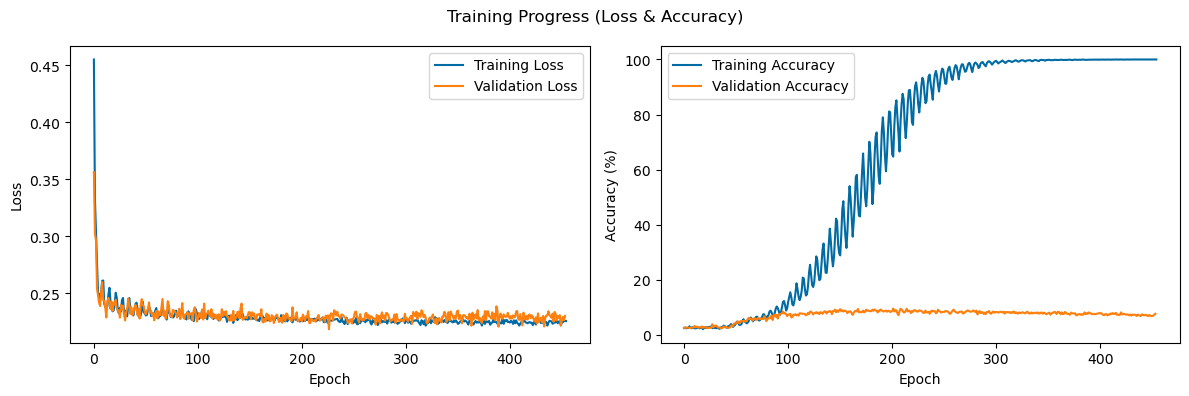

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.style.use('tableau-colorblind10')

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot([v * 100 for v in history["train_acc"]], label="Training Accuracy")
plt.plot([v * 100 for v in history["val_acc"]], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.suptitle("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.show()

#Evaluate on test data

In [15]:
diffe.eval()

# evaluate
labels = np.arange(0, 40)  # necessary change: 40 classes
Y = []
Y_hat = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        encoder_out = diffe.encoder(x)
        y_hat = diffe.fc(encoder_out[1])
        y_hat = F.softmax(y_hat, dim=1)

        Y.append(y.detach().cpu())
        Y_hat.append(y_hat.detach().cpu())

Y = torch.cat(Y, dim=0).numpy()  # (N, )
Y_indices = Y.argmax(axis=1)
Y_hat = torch.cat(Y_hat, dim=0).numpy()  # (N, 26)

accuracy = top_k_accuracy_score(Y_indices, Y_hat, k=1, labels=labels)
print(f'Test accuracy: {accuracy:.2%}')

Test accuracy: 99.33%
